# Initialization

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')  # allow importing from parent directory
from fun_gilles import *
import cmcrameri.cm as cmc

In [27]:
def mean_calculation(concentration, window_size):
    # first we get the cumulative sum at every iteration of the previous concentrations
    cumulative_sum = np.cumsum(concentration)
    
    moving_sum = cumulative_sum[window_size:] - cumulative_sum[:-window_size]
    
    moving_mean = moving_sum / window_size
    
    return moving_mean

def std_devCalculation(concentration, W):
    # each row in 'window_view' is a window of size W
    window_view = np.lib.stride_tricks.sliding_window_view(concentration, window_shape=W)

    # calculate the rolling standard deviation
    rolling_std = np.std(window_view, axis=1)
    return rolling_std[1:]

def block_statistics(concentration, W):
    """
    Calculates the mean and standard deviation for non-overlapping blocks.
    W is the block size (e.g., 100).
    """
    N = len(concentration)
    
    # 1. Determine the number of complete blocks
    num_complete_blocks = N // W
    
    # 2. Slice the data to discard the remainder (if any)
    sliced_concentration = concentration[:num_complete_blocks * W]

    # 3. Reshape the data into blocks (e.g., 100 blocks of 100 iterations)
    # Each row is now a block of W iterations.
    blocked_data = sliced_concentration.reshape(num_complete_blocks, W)

    # 4. Calculate the mean and standard deviation along axis=1 (across the W iterations)
    block_mean = np.mean(blocked_data, axis=1)
    block_std = np.std(blocked_data, axis=1)
    
    return block_mean, block_std

In [28]:
def plot_conc_mean_dev(time, abundances, W, species, ab = "Abundances"):
    
    time_rolling_N_W = time[W:]
    colors = cmc.berlin(np.linspace(0, 1, len(species)))
    

    # 2. Create the Figure and Subplots
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 8)) # 3 rows, 1 column, shared X-axis

    # --- Subplot 1: abundance vs. Time ---
    ax1 = axes[0]
    for i in range(len(species)):
        ax1.plot(time, abundances[:, i], label=f'{species[i]}', color=colors[i], alpha=0.9)
    ax1.set_ylabel(f'{ab}')
    ax1.grid(True, linestyle=':', alpha=0.6)
    ax1.legend(loc='upper right')

    # --- Subplot 2: Rolling Mean (meancon) vs. Time ---
    ax2 = axes[1]
    # Plot the rolling mean against the aligned time vector
    for i in range(len(species)):
        meancon = mean_calculation(abundances[:,i], W)
        ax2.plot(time_rolling_N_W, meancon, label=f'{species[i]}', color=colors[i], alpha=0.9)
    ax2.set_ylabel('Mean')
    ax2.grid(True, linestyle=':', alpha=0.6)
    ax2.legend(loc='upper right')

    # --- Subplot 3: Rolling Std. Dev. (devcon) vs. Time ---
    ax3 = axes[2]
    # Plot the ALIGNED rolling standard deviation
    for i in range(len(species)):
        devcon = std_devCalculation(abundances[:,i], W)
        ax3.plot(time_rolling_N_W, devcon, label=f'{species[i]}', color=colors[i], alpha=0.9)
    ax3.set_ylabel('Std. Dev.')
    ax3.set_xlabel('Time (Iteration Number)')
    ax3.grid(True, linestyle=':', alpha=0.6)
    ax3.legend(loc='upper right')

    # Final adjustments
    plt.tight_layout() # Adjusts subplot parameters for a tight layout
    plt.show()

In [29]:
def plotDistribution(W_last, abundances, species, ab= "Abundance"):
    # 1. Isolate the data for the last 1000 iterations
    # Slicing the last 1000 rows (iterations) and all columns (species)
    abundances_last_1000 = abundances[-W_last:, :]

    # 2. Get the dimensions for plotting
    num_species = abundances_last_1000.shape[1]

    # 3. Create the figure and subplots
    fig, axes = plt.subplots(1, num_species, figsize=(4 * num_species, 6), squeeze=False)
    fig.suptitle(f'Distribution of {ab}s in the Last {W_last} Iterations', fontsize=14)

    # 4. Loop through each species and plot the histogram
    for i in range(num_species):
        ax = axes[0, i]
        data = abundances_last_1000[:, i]
        
        # Calculate key statistics for annotation
        mean_val = np.mean(data)
        std_val = np.std(data)
        
        # Plot the histogram
        ax.hist(data, density=True, color='skyblue', edgecolor='black', alpha=0.7)
        
        # Fit and plot a Normal distribution for comparison
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = 1 / (np.sqrt(2 * np.pi) * std_val) * np.exp(-0.5 * ((x - mean_val) / std_val)**2)
        ax.plot(x, p, 'k', linewidth=2, label='Normal Fit')
        
        # Add mean line and text annotation
        ax.axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label='Mean')
        ax.text(0.05, 0.95, 
                f'Mean: {mean_val:.1f}\nStd. Dev.: {std_val:.2f}', 
                transform=ax.transAxes, 
                verticalalignment='top', 
                fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.6))

        ax.set_title(f'{species[i]}')
        ax.set_xlabel(f'{ab}')
        ax.set_ylabel('Probability Density')
        ax.grid(axis='y', linestyle=':', alpha=0.6)
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [30]:
def plot_block_statistics(concentration, W, species, ab= 'Abundance', limit= 0):
    # Calculate statistics using your existing function
    
    N = len(concentration)
    num_complete_blocks = N // W
    
    # --- NEW TIME AXIS CALCULATION ---
    # 1. Determine the time offset (the center of the first block)
    start_time = W / 2
    
    # 2. Create the time vector for the blocks
    # It starts at the center of the first block and increments by W (the block size)
    # The length must match the number of blocks.
    block_time = start_time + np.arange(num_complete_blocks) * W

    # --- PLOTTING ---
    
    # 1. Plot the raw concentration data (for context)
    time = np.arange(N)
    limit = np.ones_like(block_time)*limit
    
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 8)) 
    colors = cmc.berlin(np.linspace(0, 1, len(species)))    
    # Subplot 1: Full Trajectory (for context)
    ax1 = axes[0]
    for i in range(len(species)):
        ax1.plot(time, concentration[:,i], label=f'{species[i]}', color= colors[i], alpha=0.9)
    
    ax1.set_ylabel(f'{ab}')
    ax1.set_title(f'Gillespie Simulation: Block Averaging (Block Size $W={W}$)')
    ax1.legend(loc='upper right')

    # Subplot 2: Block Mean vs. Time
    ax2 = axes[1]
    # Plot the block mean against the new time vector
    for i in range(len(species)):
        block_mean = block_statistics(concentration[:,i], W)[0]
        ax2.plot(block_time, block_mean, label=f'{species[i]}', color= colors[i], marker='o', linestyle='-', linewidth=1, markersize=3)
    ax2.set_ylabel('Block Mean')
    ax2.grid(True, linestyle=':', alpha=0.6)
    ax2.legend(loc='upper right')

    # Subplot 3: Block Std. Dev. vs. Time
    ax3 = axes[2]
    for i in range(len(species)):
        block_std = block_statistics(concentration[:,i], W)[1]
        # Plot the block standard deviation against the new time vector
        ax3.plot(block_time, block_std, label=f'{species[i]}', color= colors[i], marker='s', linestyle='-', linewidth=1, markersize=3)
    ax3.plot(block_time, limit, color= 'gray')
    ax3.set_ylabel('Block Std. Dev.')
    ax3.set_xlabel('Time (Iteration Number)')
    ax3.grid(True, linestyle=':', alpha=0.6)
    ax3.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Sistema XY

Voy a comenzar con el sistema más sencillo hasta el momento, ya que es el más fácil para calcular el equilibrio a mano.

$X + Y \longleftrightarrow XY$

## Ruido de la simulación -> 1000

In [6]:

file = "../examples/reactions_XY.txt"
reactions = read_file(file)
species = obtain_species(reactions)
c_matrix_wo_food = c_matrix(reactions[reactions[:,-1]!='4'], obtain_species(reactions))
print(matrix_rank(c_matrix_wo_food))
print(c_matrix_wo_food.shape[0])
print(c_matrix_wo_food)
k = [1, 1]
initial = [1000,1000,0]
volume = 1000

iterations = 40000
abundances, times, V = chemistry(method= "Protocell", iterations= iterations, reactions= reactions, initial_food= initial,
                                k= k, V = volume)

concentration = (abundances.T / volume).T

1
2
[[-1. -1.  1.]
 [ 1.  1. -1.]]


### W = 100

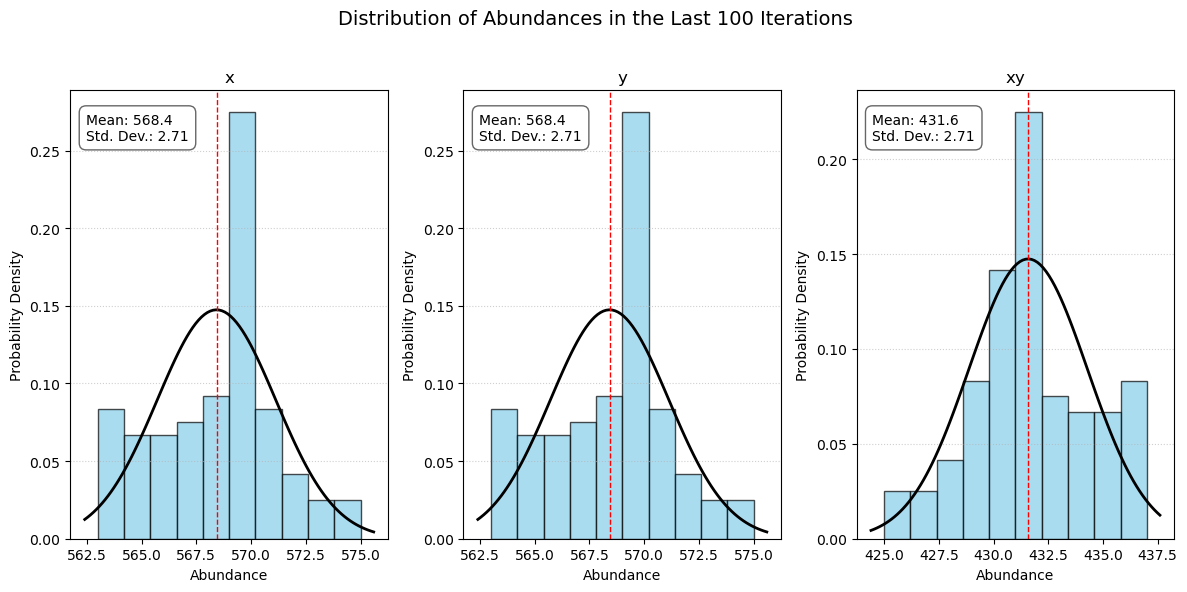

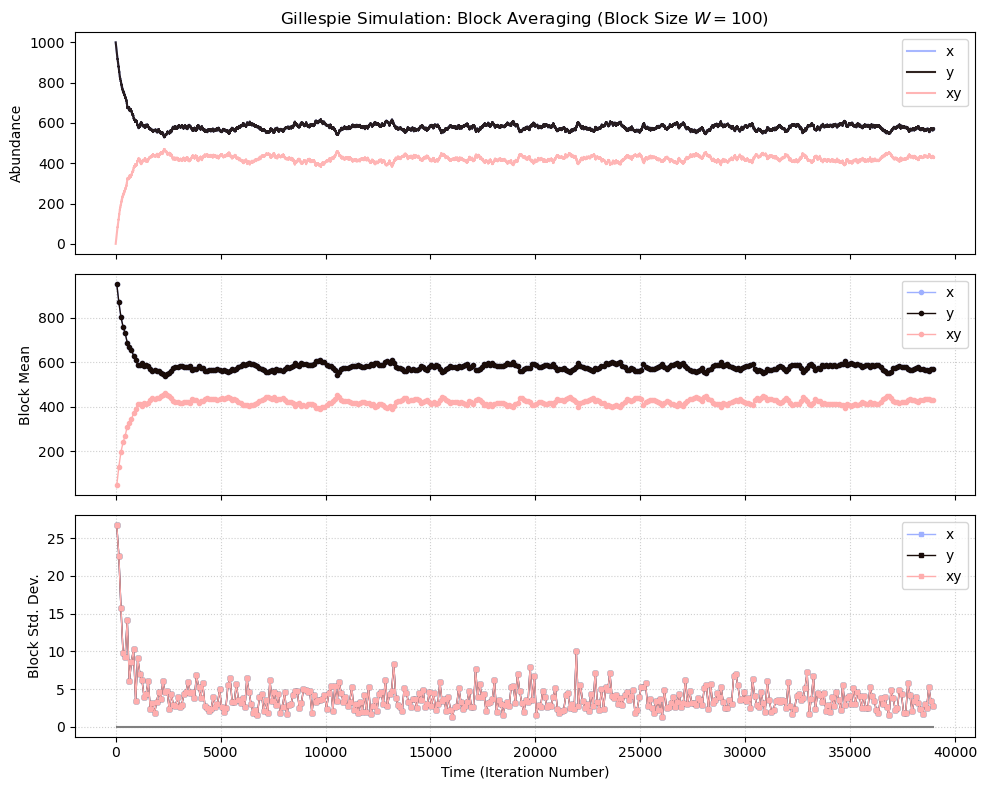

0.01282490631323907


In [9]:

W = 100
t = threshold_function(volume)
plotDistribution(W, abundances, species)
plot_block_statistics(abundances, W, species,limit=t)
mean, std = block_statistics(abundances[:,0], W)
np.sum(std<t)
print(t)

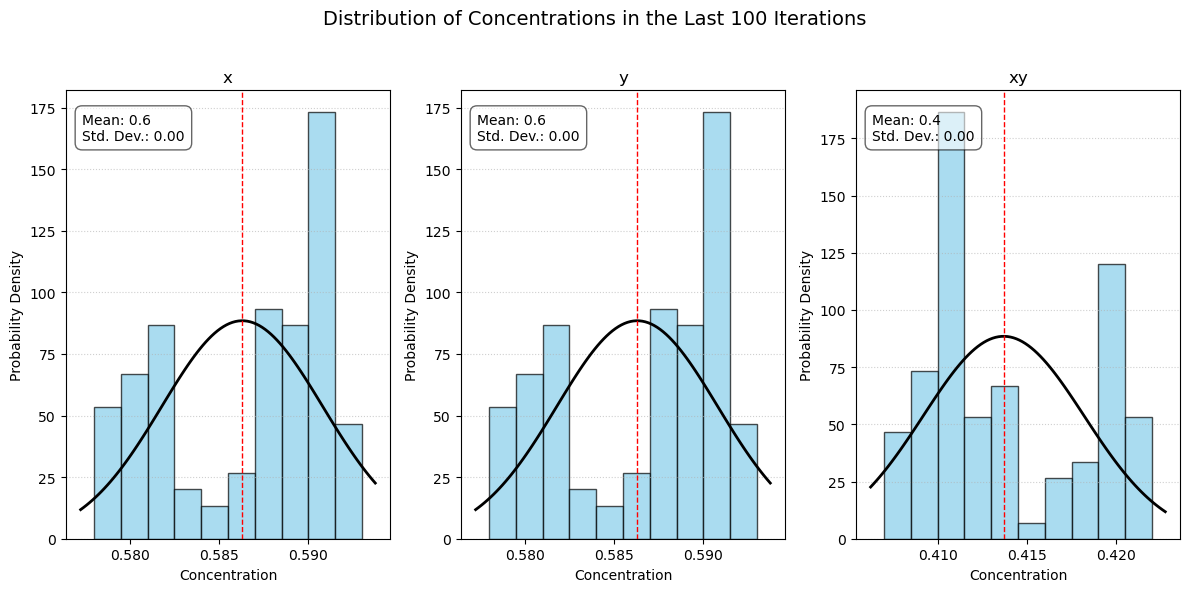

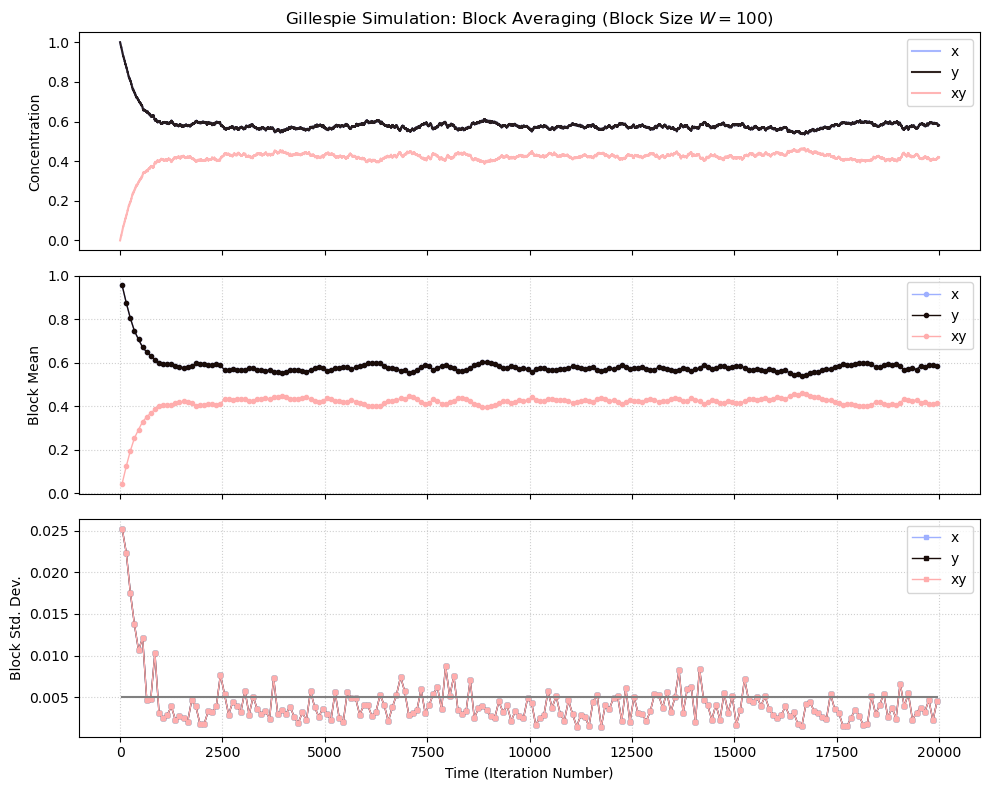

In [ ]:
plotDistribution(W, concentration, species, ab= "Concentration")
plot_block_statistics(concentration, W, species, ab= "Concentration", limit=0.005)

### W = 500

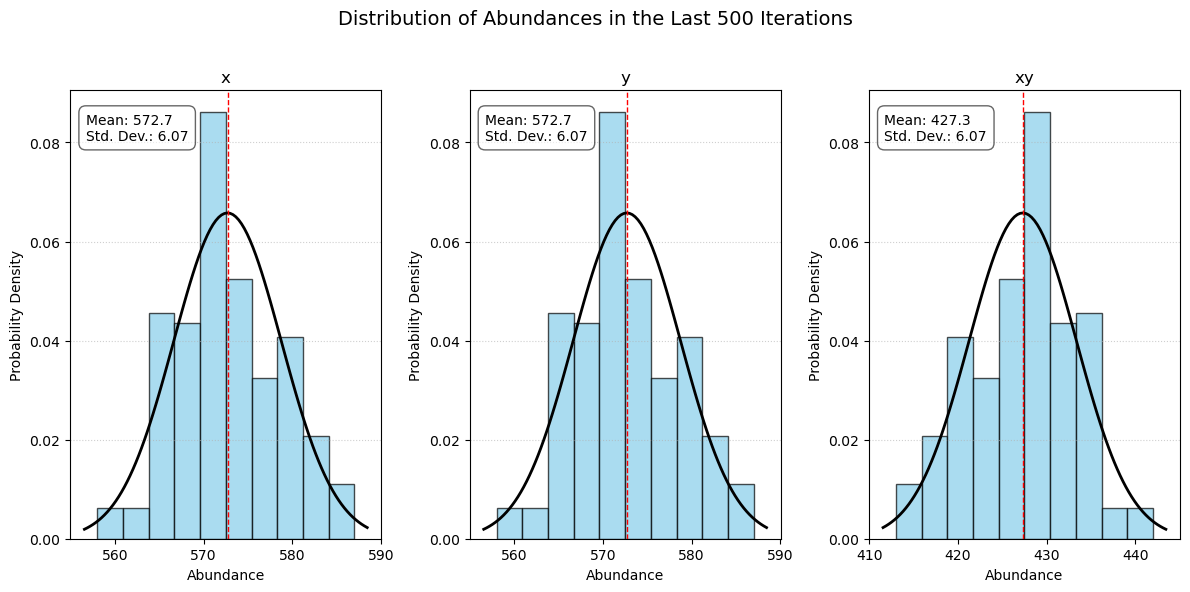

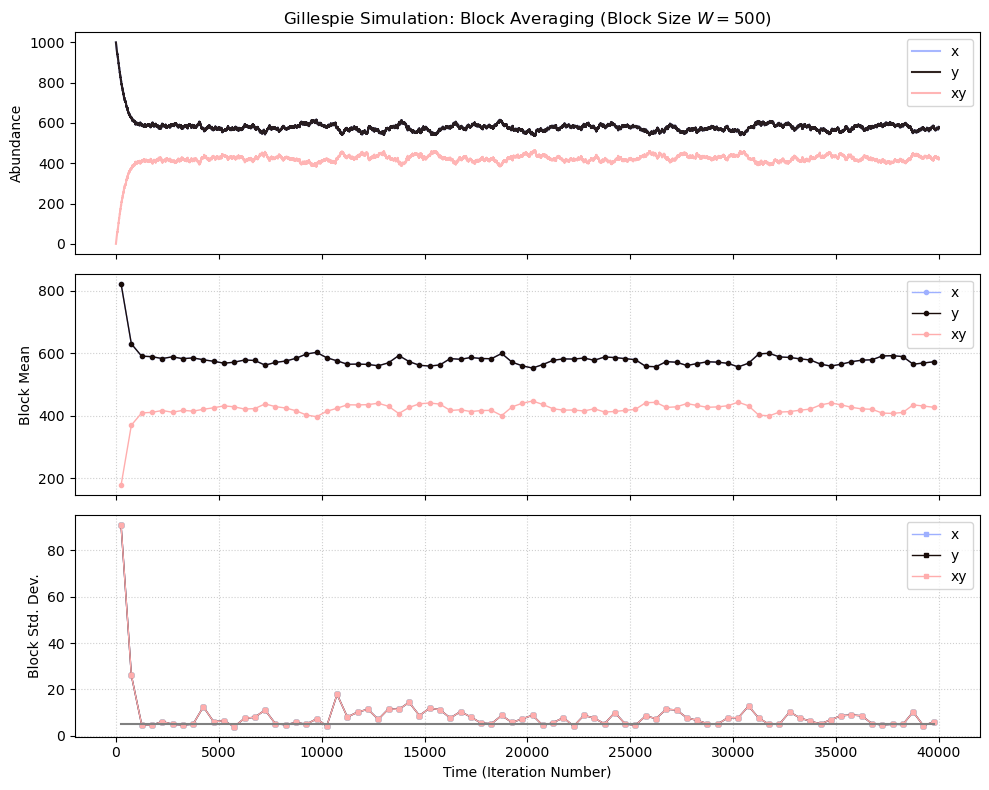

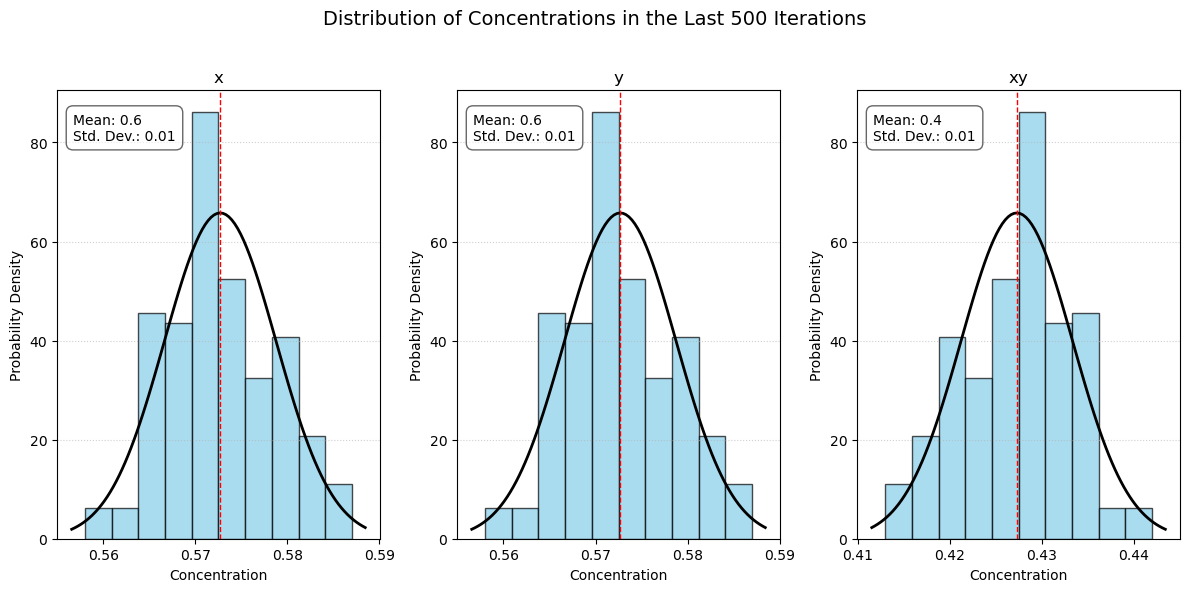

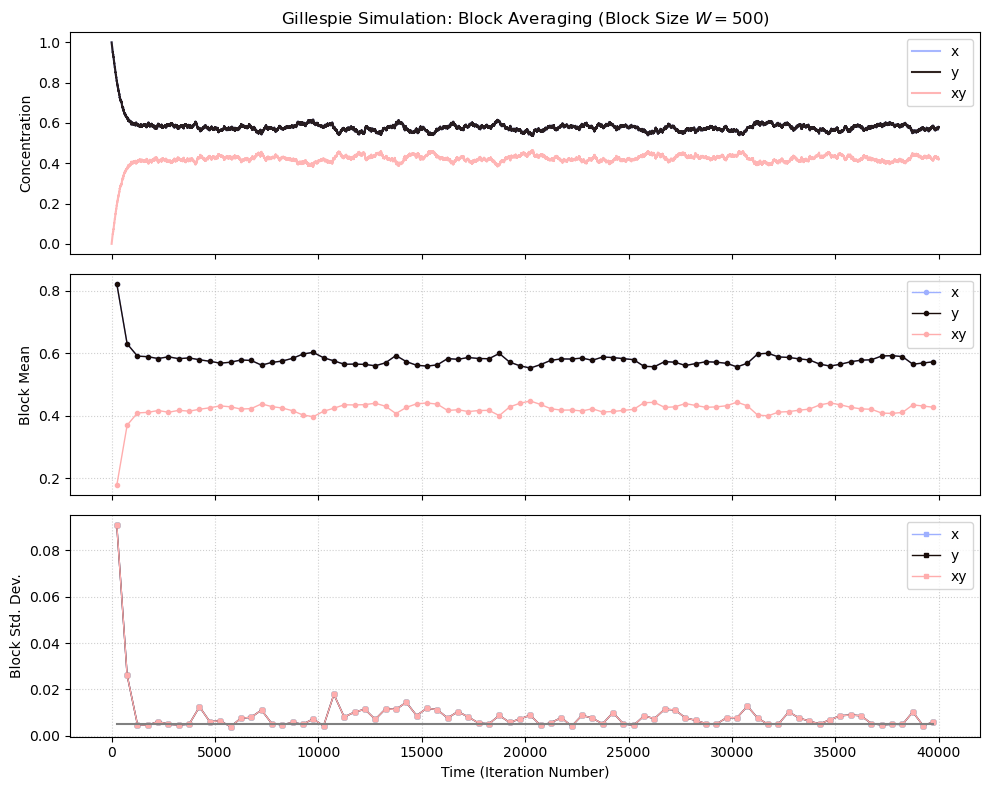

In [ ]:
W = 500
plotDistribution(W, abundances, species)
plot_block_statistics(abundances, W, species, limit= 5)
plotDistribution(W, concentration, species, ab= "Concentration")
plot_block_statistics(concentration, W, species, ab= "Concentration", limit= 0.005)

In [ ]:
for i in range(len(species)):
    mean, std = block_statistics(concentration[:,i], W)
    print(f'{species[i]} -> {np.sum(std<0.005)}')

x -> 13
y -> 13
xy -> 13


### W = 1000

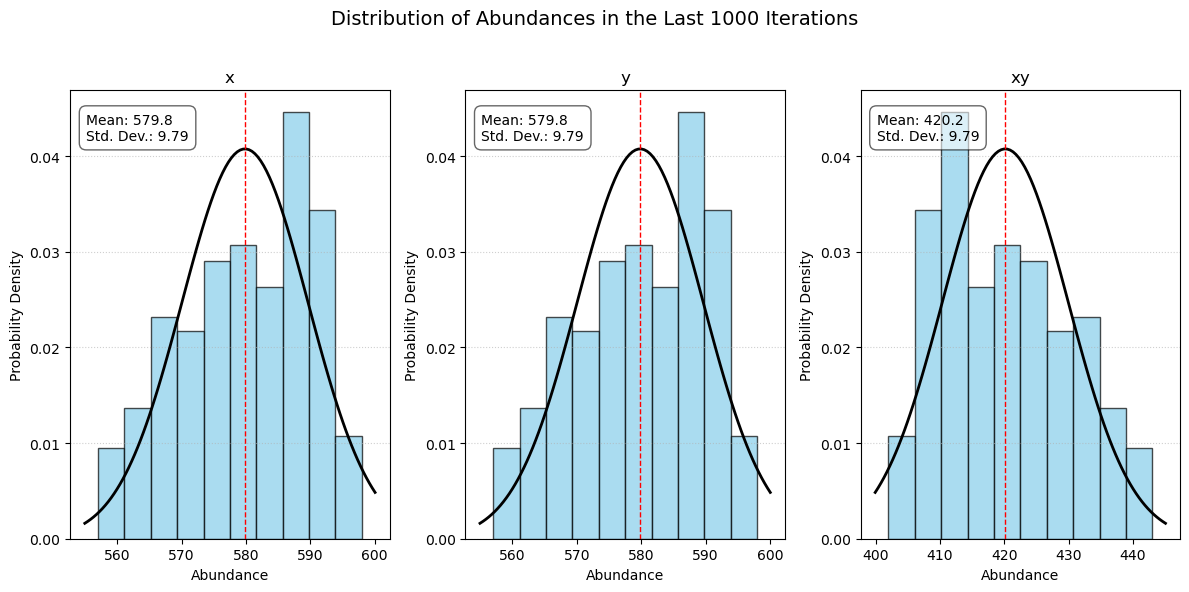

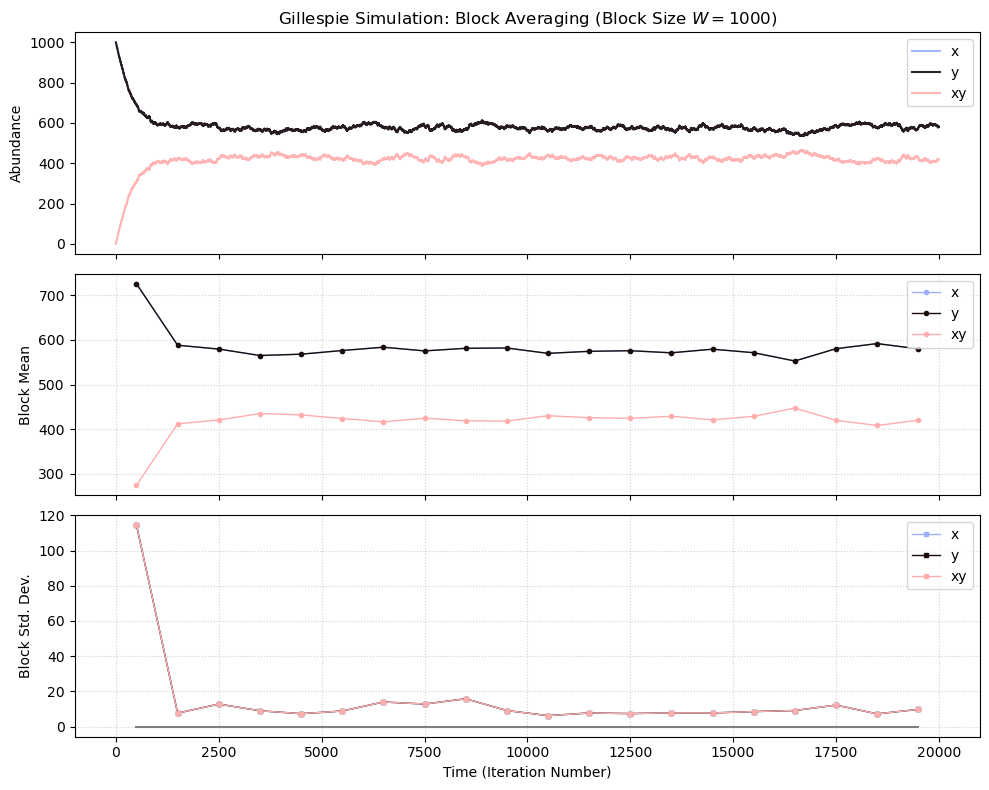

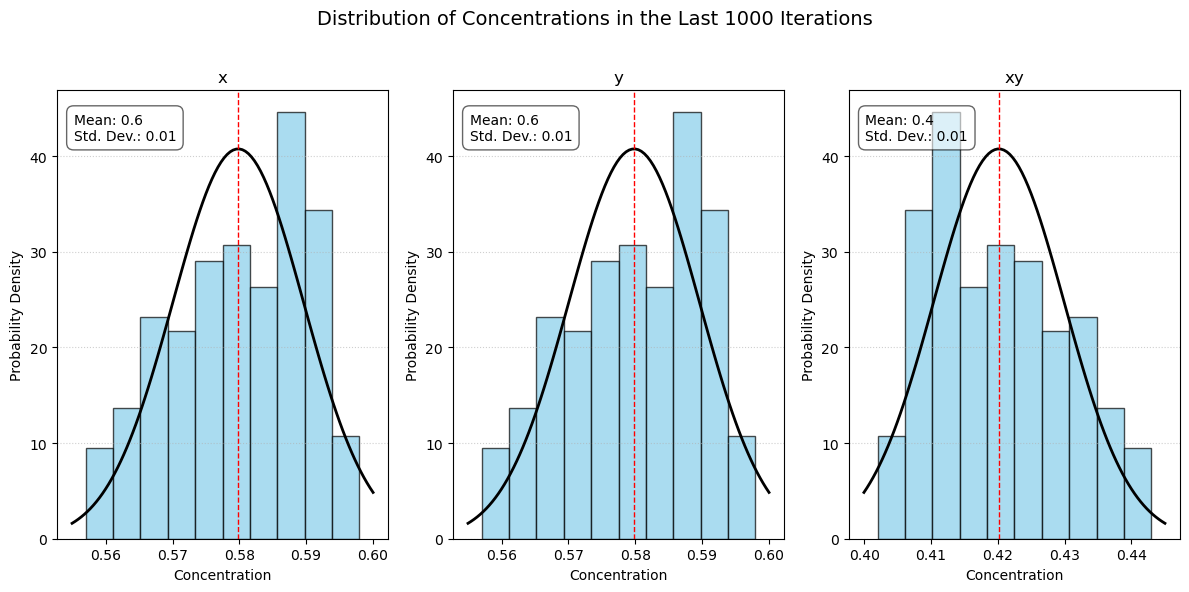

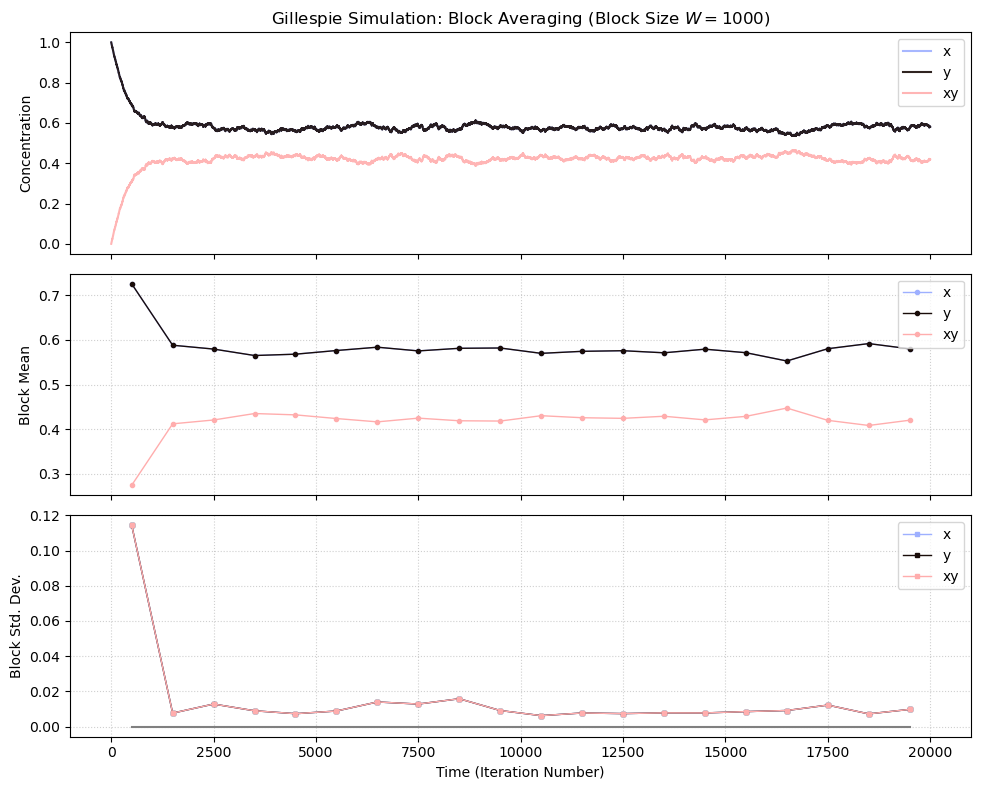

In [ ]:
W = 1000
plotDistribution(W, abundances, species)
plot_block_statistics(abundances, W, species)
plotDistribution(W, concentration, species, ab= "Concentration")
plot_block_statistics(concentration, W, species, ab= "Concentration")

## Ruido de la simulación -> 100

In [ ]:

file = "examples/reactions_XY.txt"
reactions = read_file(file)
species = obtain_species(reactions)

k = [1, 1]
initial = [100,100,0]
volume = 100

iterations = 4000
abundances, times, V = chemistry(method= "Gillespie", iterations= iterations, reactions= reactions, initial_food= initial,
                                k= k, V = volume)

concentration = (abundances.T / volume).T

### W = 50

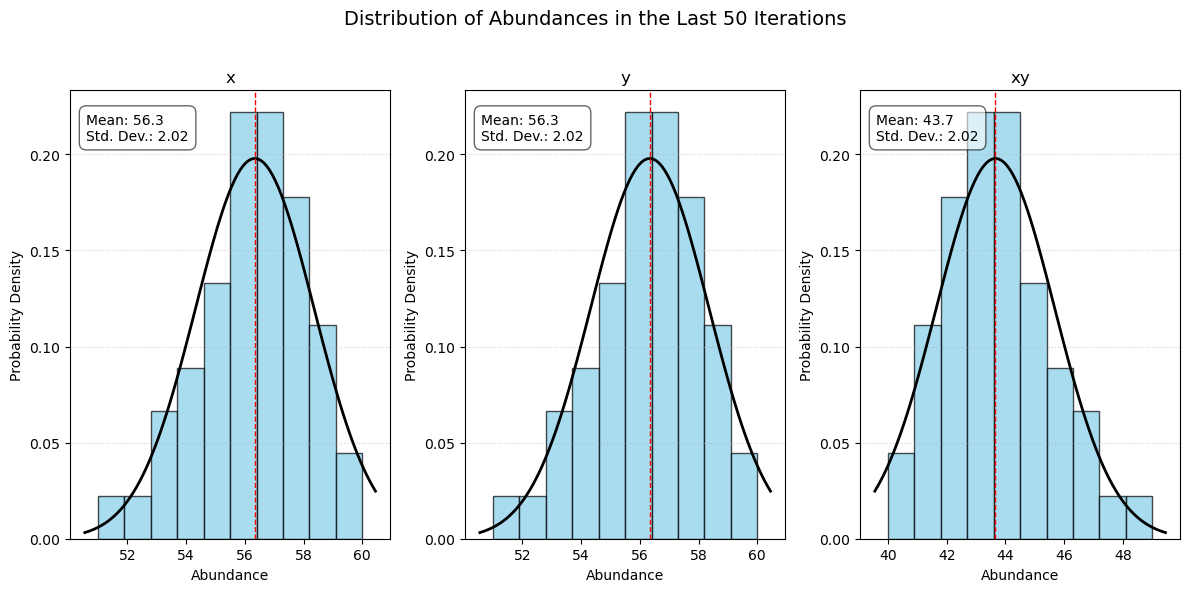

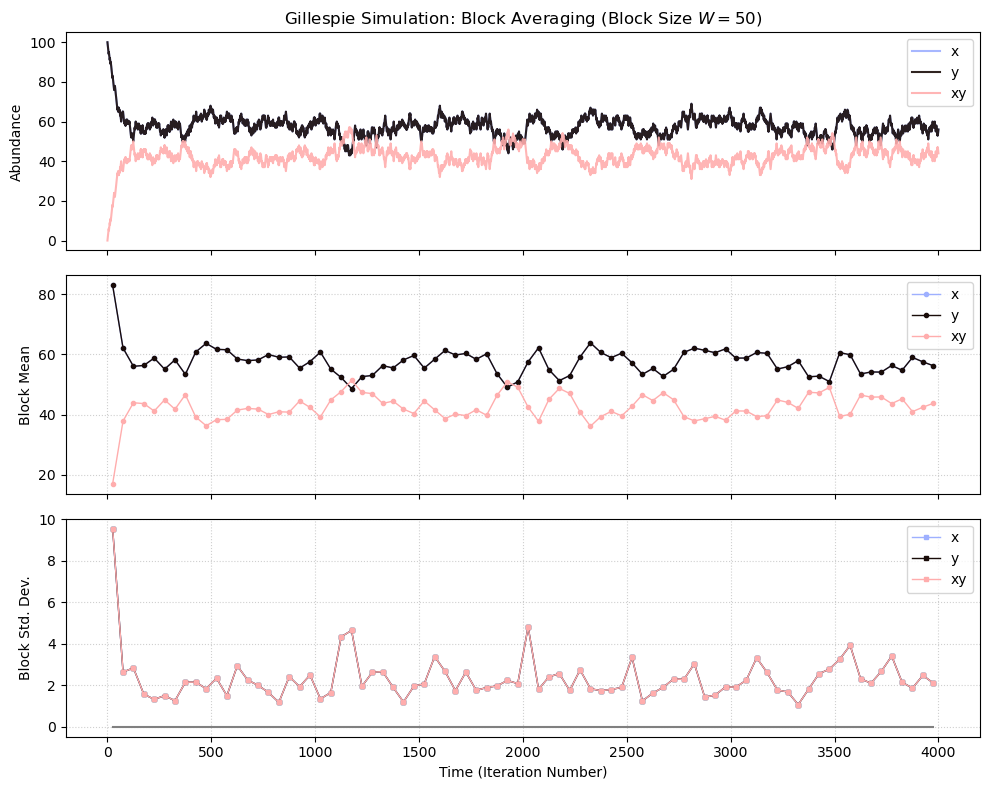

In [ ]:
W = 50
plotDistribution(W, abundances, species)
plot_block_statistics(abundances, W, species)

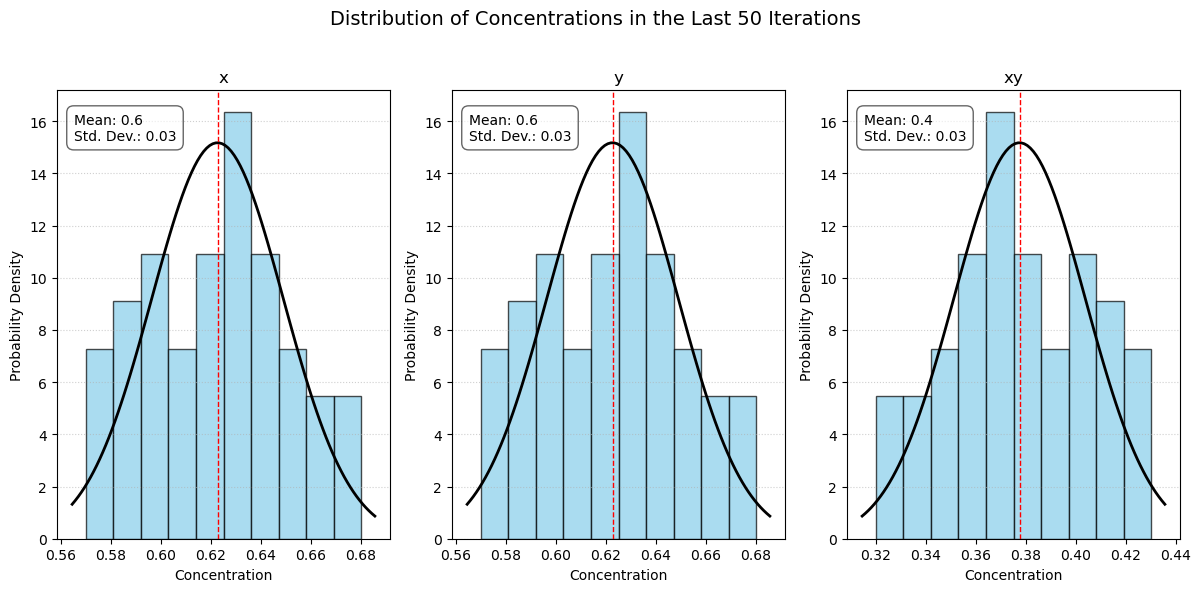

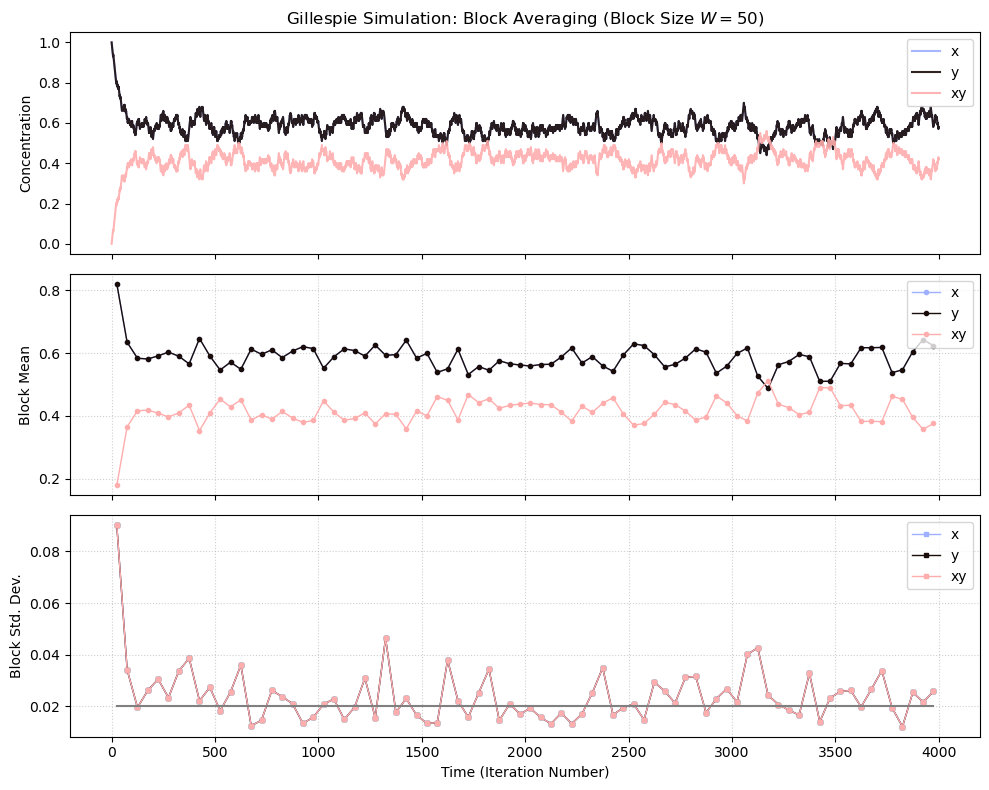

In [ ]:
plotDistribution(W, concentration, species, ab= "Concentration")
plot_block_statistics(concentration, W, species, ab= "Concentration", limit=0.02)

In [ ]:
for i in range(len(species)):
    mean, std = block_statistics(concentration[:,i], W)
    print(f'{species[i]} -> {np.sum(std<0.02)}')

x -> 32
y -> 32
xy -> 32


### W = 100

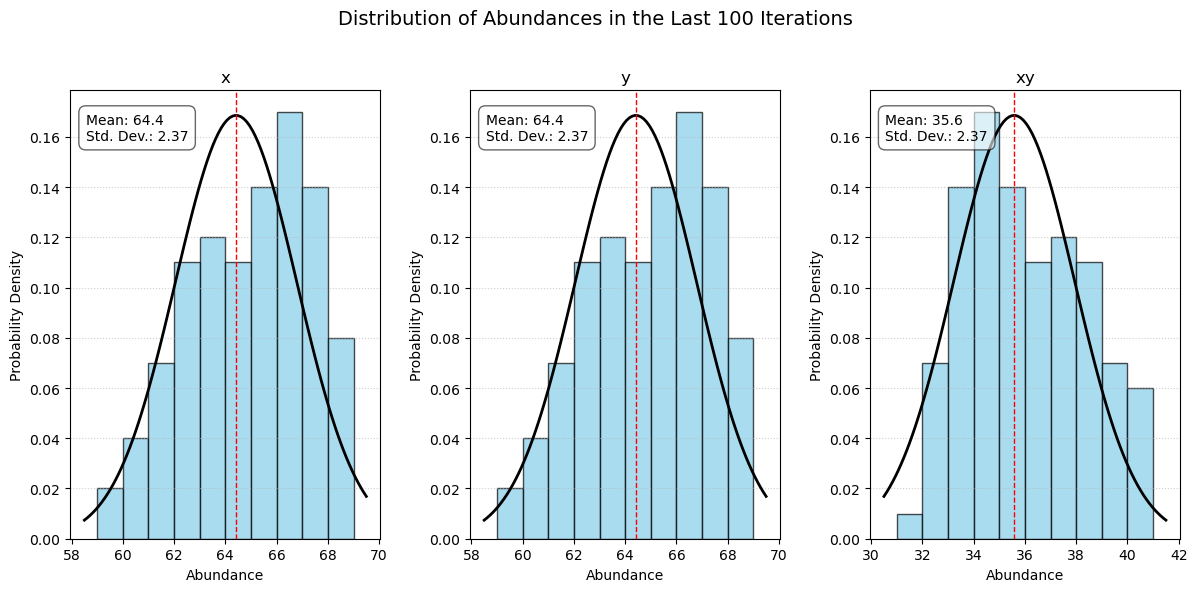

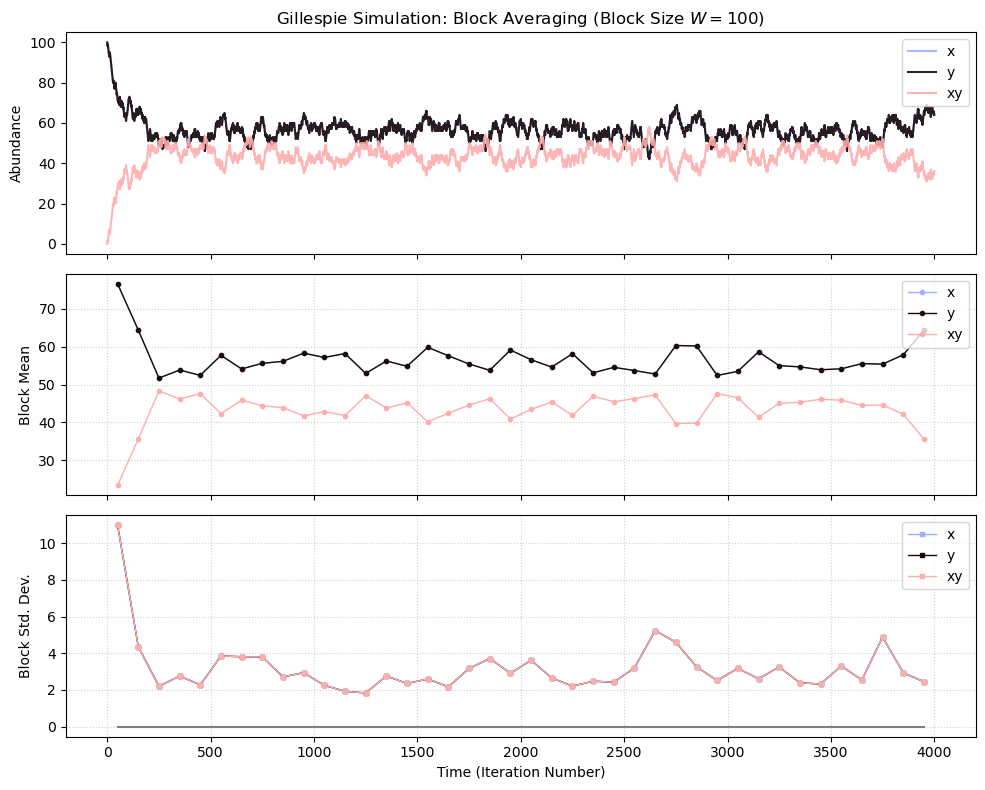

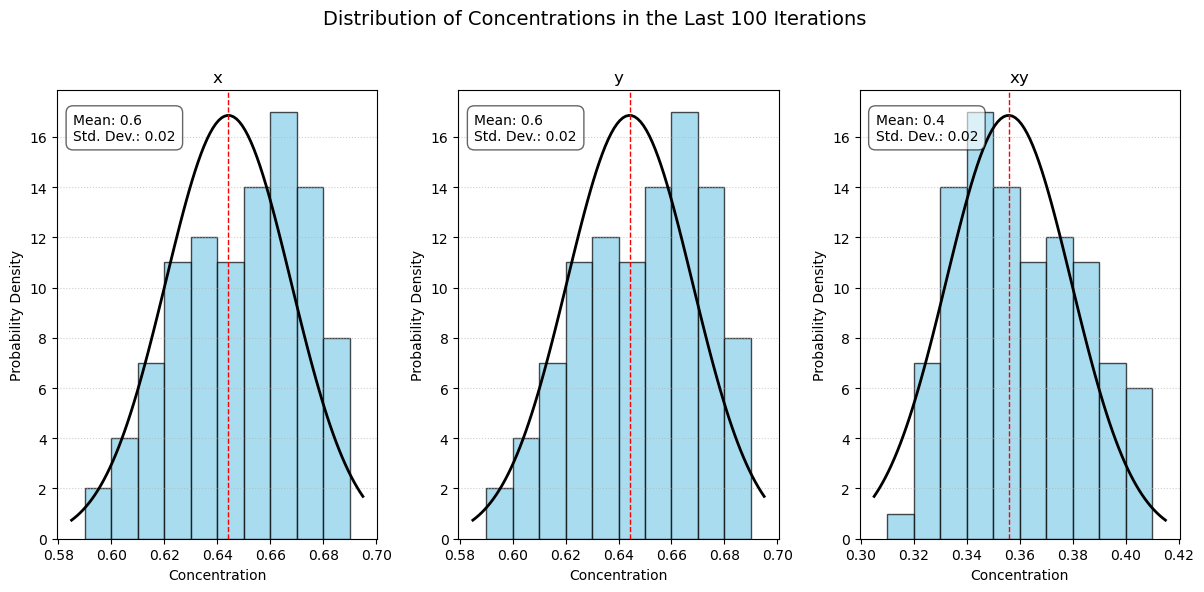

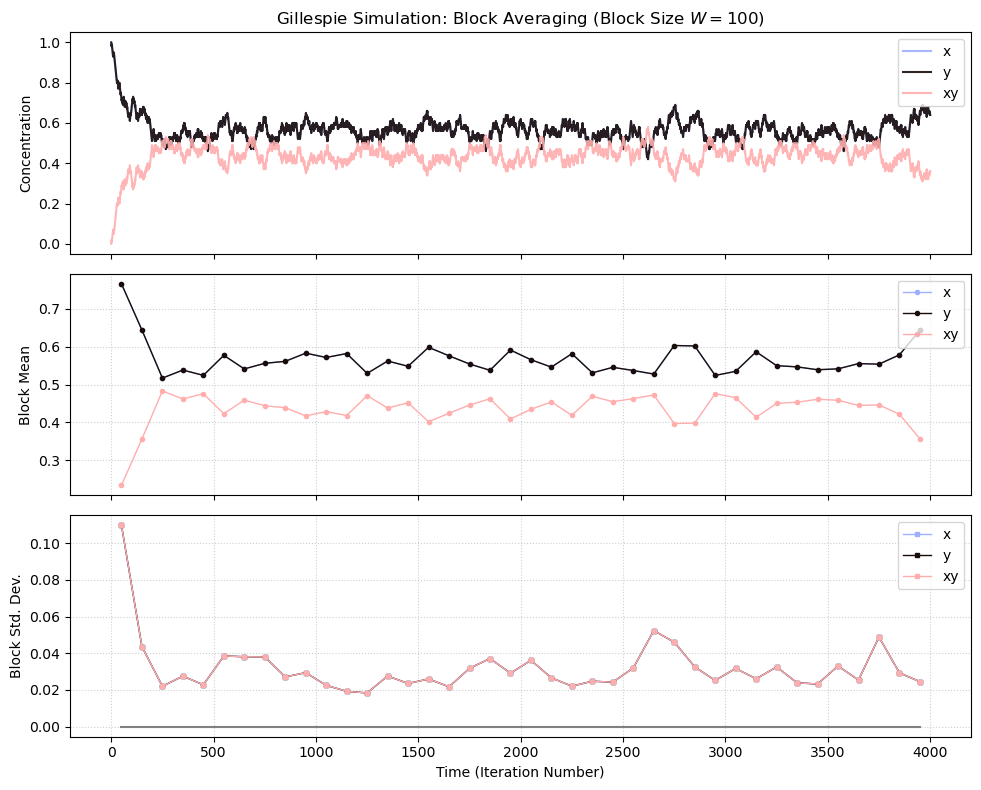

In [ ]:
W = 100
plotDistribution(W, abundances, species)
plot_block_statistics(abundances, W, species)
plotDistribution(W, concentration, species, ab= "Concentration")
plot_block_statistics(concentration, W, species, ab= "Concentration")

### W = 500

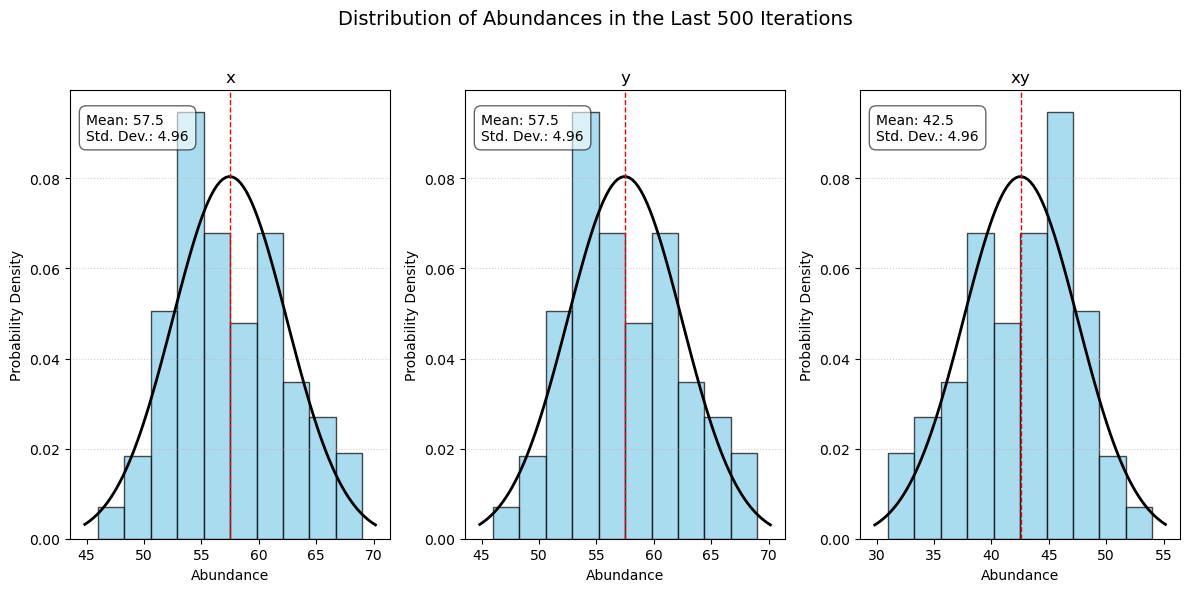

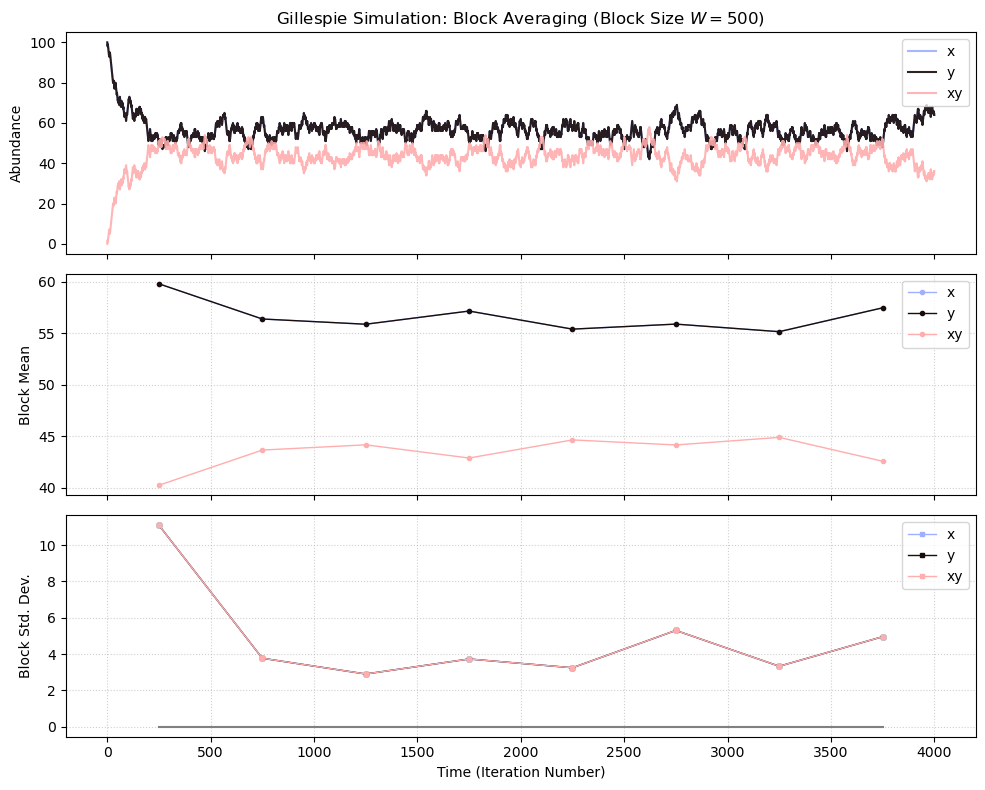

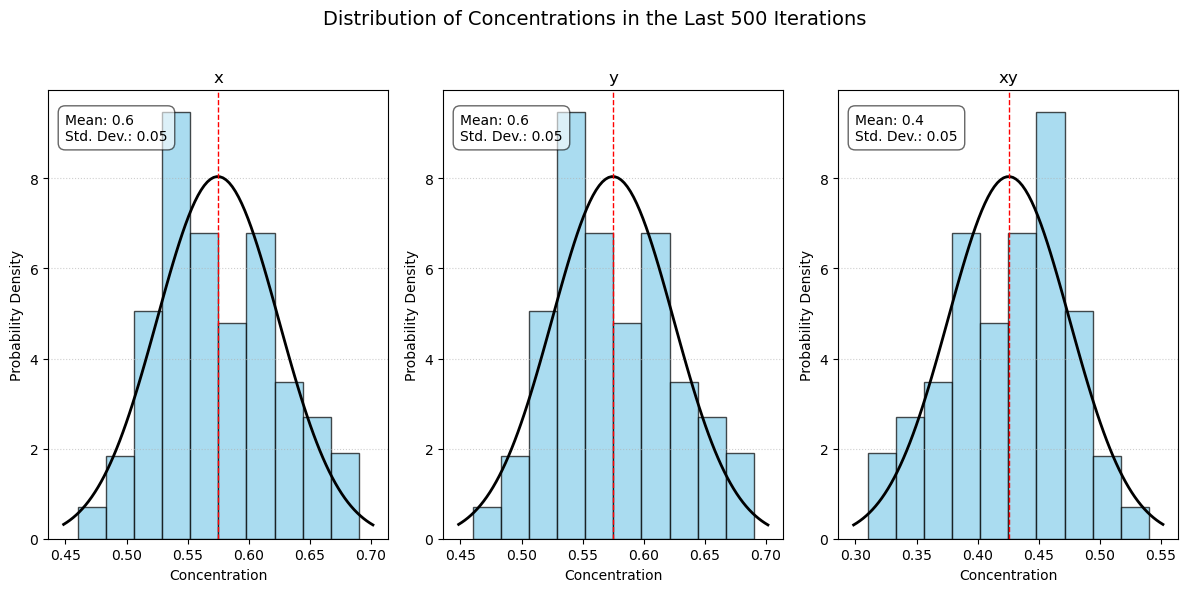

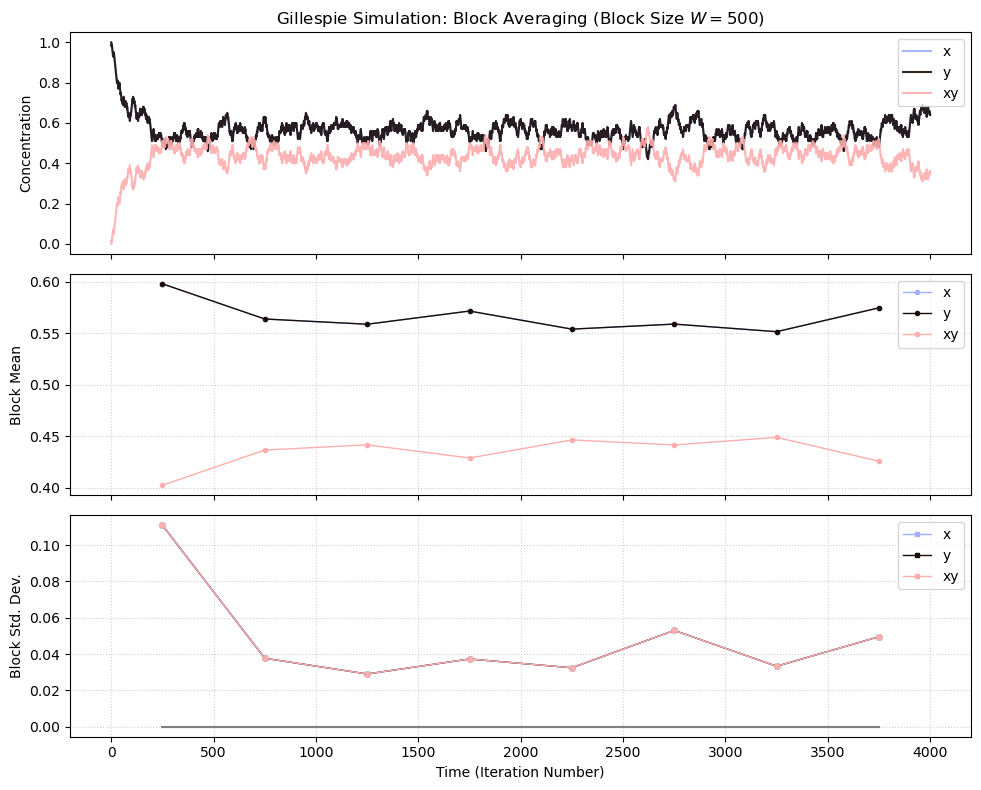

In [ ]:
W = 500
plotDistribution(W, abundances, species)
plot_block_statistics(abundances, W, species)
plotDistribution(W, concentration, species, ab= "Concentration")
plot_block_statistics(concentration, W, species, ab= "Concentration")

## Ruido de la simulación -> 10

In [ ]:

file = "examples/reactions_XY.txt"
reactions = read_file(file)
species = obtain_species(reactions)

k = [1, 1]
initial = [10,10,0]
volume = 10

iterations = 500
abundances, times, V = chemistry(method= "Gillespie", iterations= iterations, reactions= reactions, initial_food= initial,
                                k= k, V = volume)

concentration = (abundances.T / volume).T

### W = 5

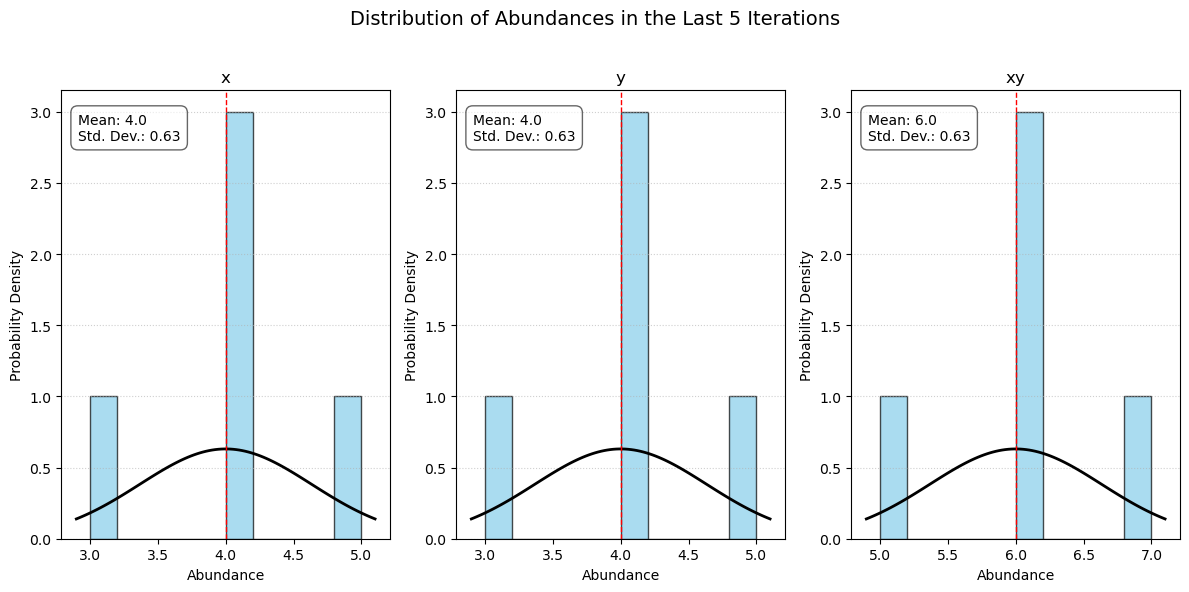

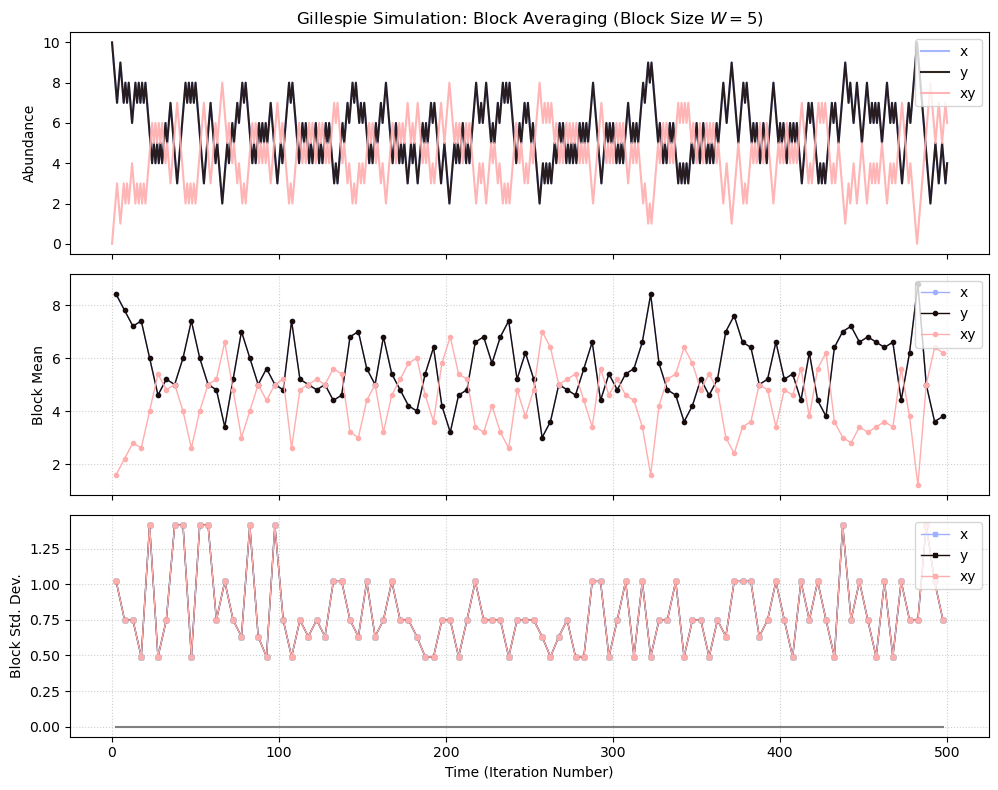

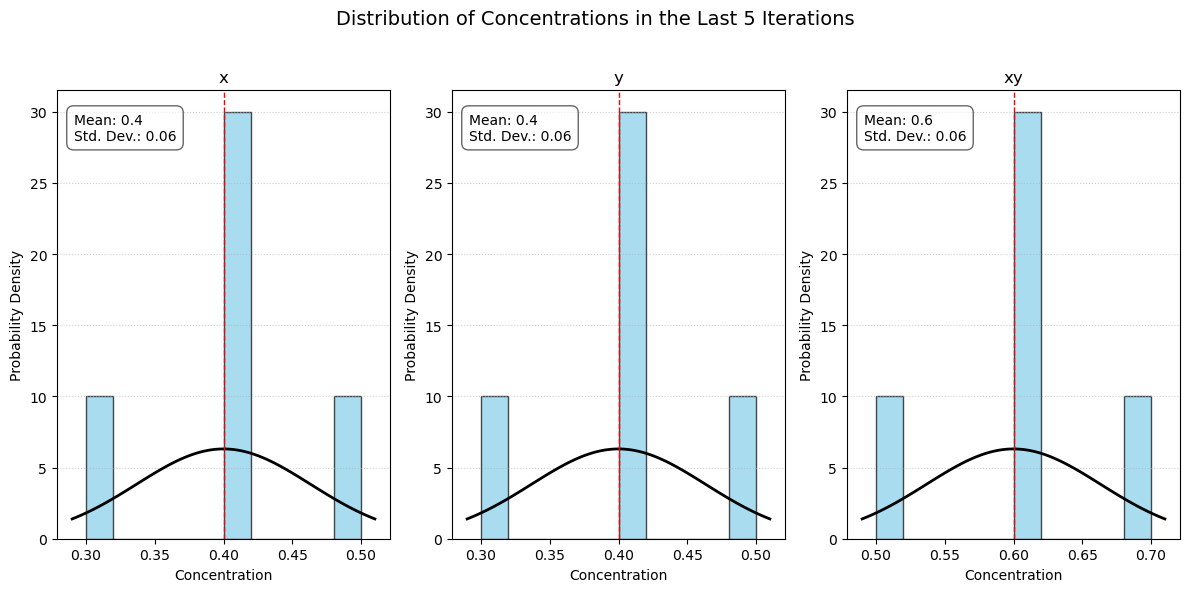

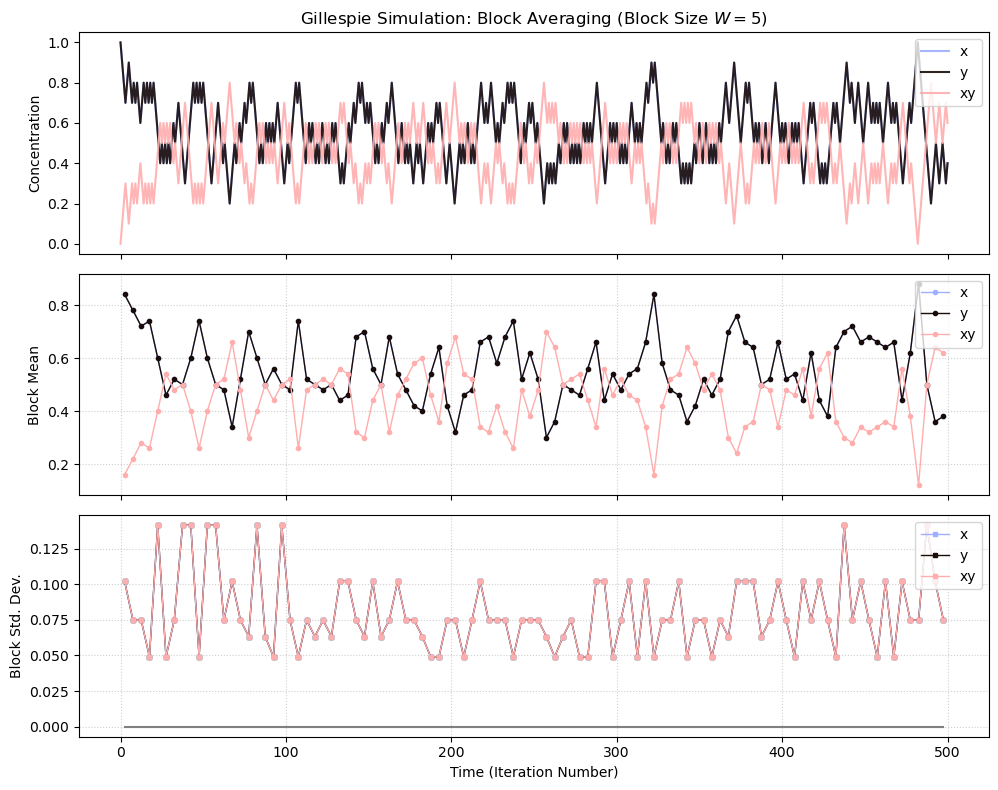

In [ ]:
W = 5
plotDistribution(W, abundances, species)
plot_block_statistics(abundances, W, species)
plotDistribution(W, concentration, species, ab= "Concentration")
plot_block_statistics(concentration, W, species, ab= "Concentration")

### W = 10

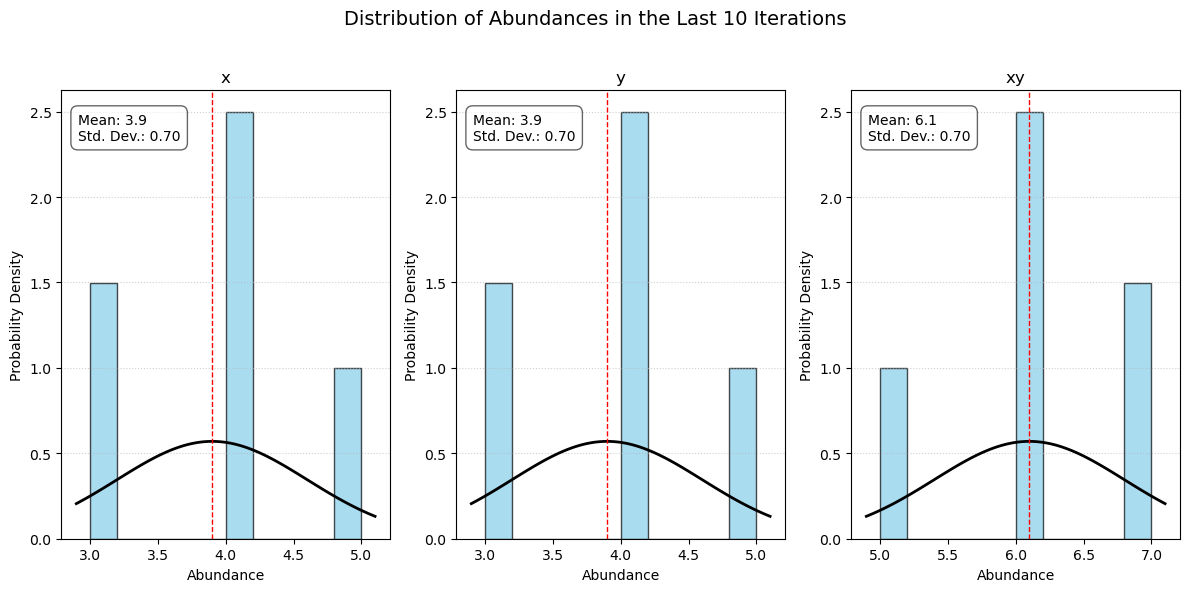

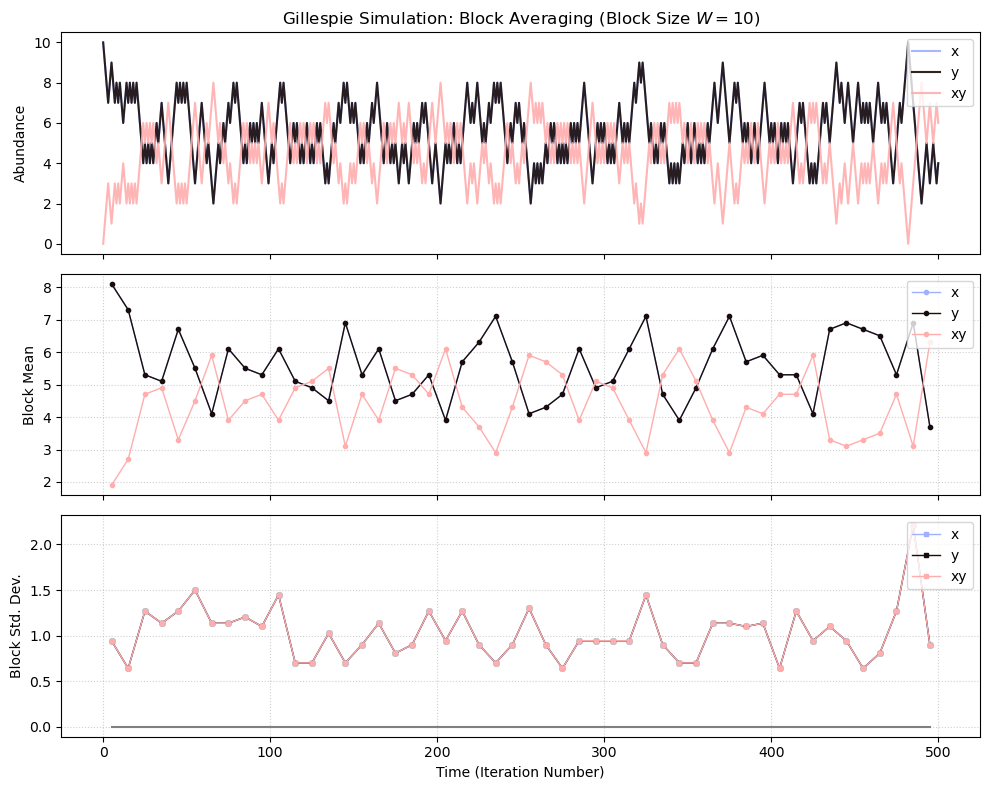

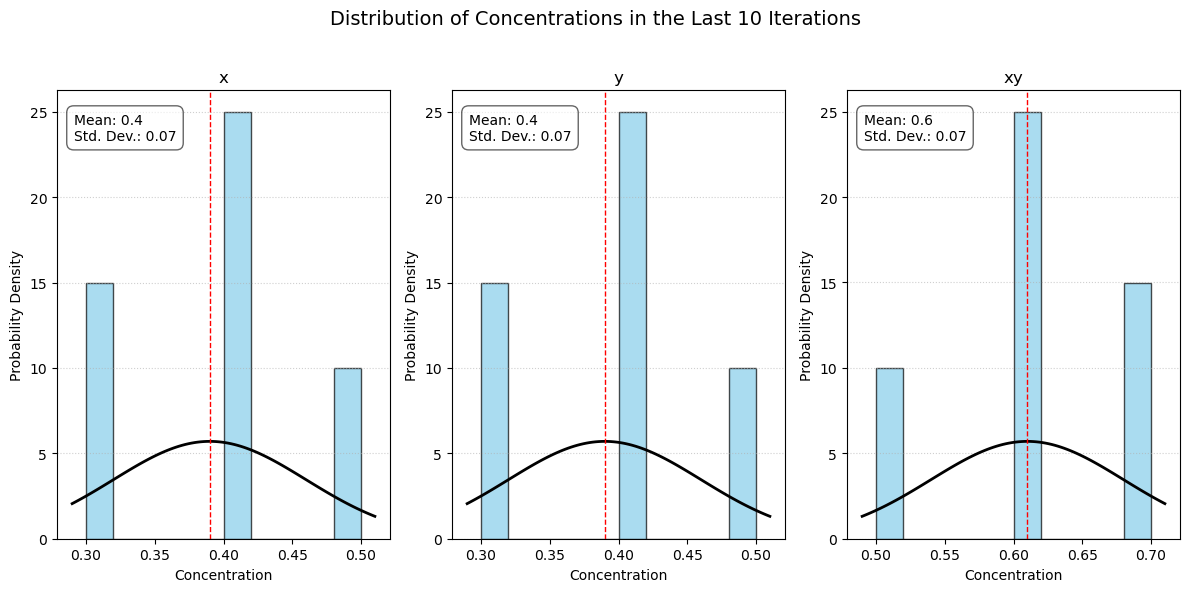

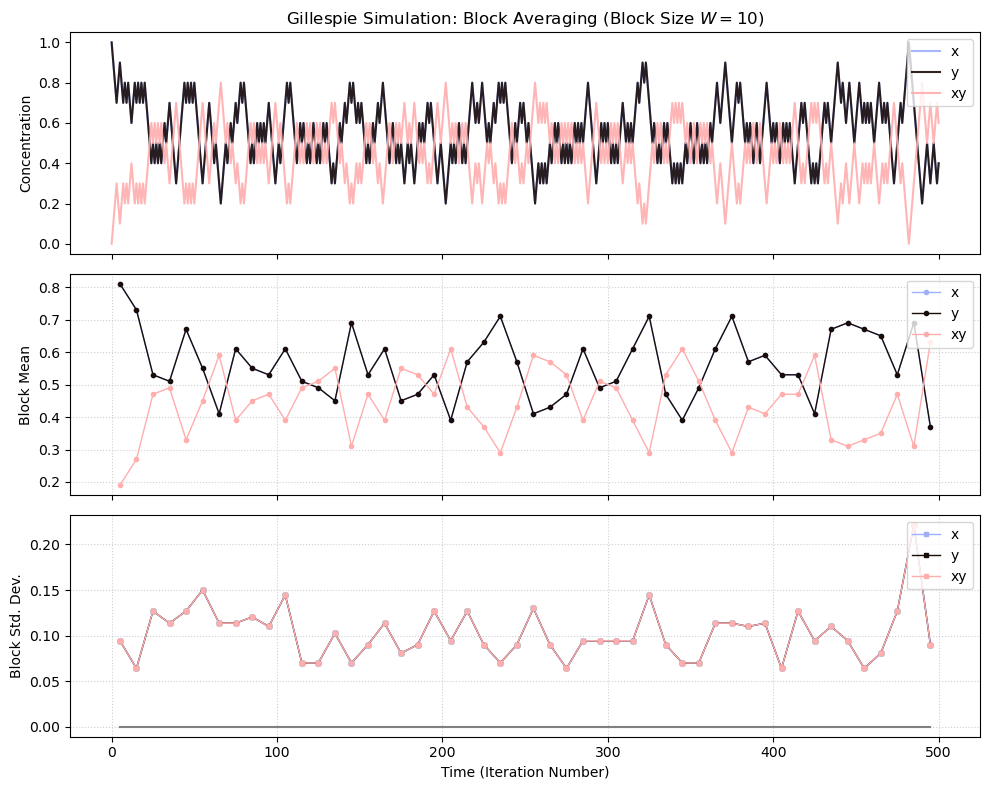

In [ ]:
W = 10
plotDistribution(W, abundances, species)
plot_block_statistics(abundances, W, species)
plotDistribution(W, concentration, species, ab= "Concentration")
plot_block_statistics(concentration, W, species, ab= "Concentration")

### W = 20

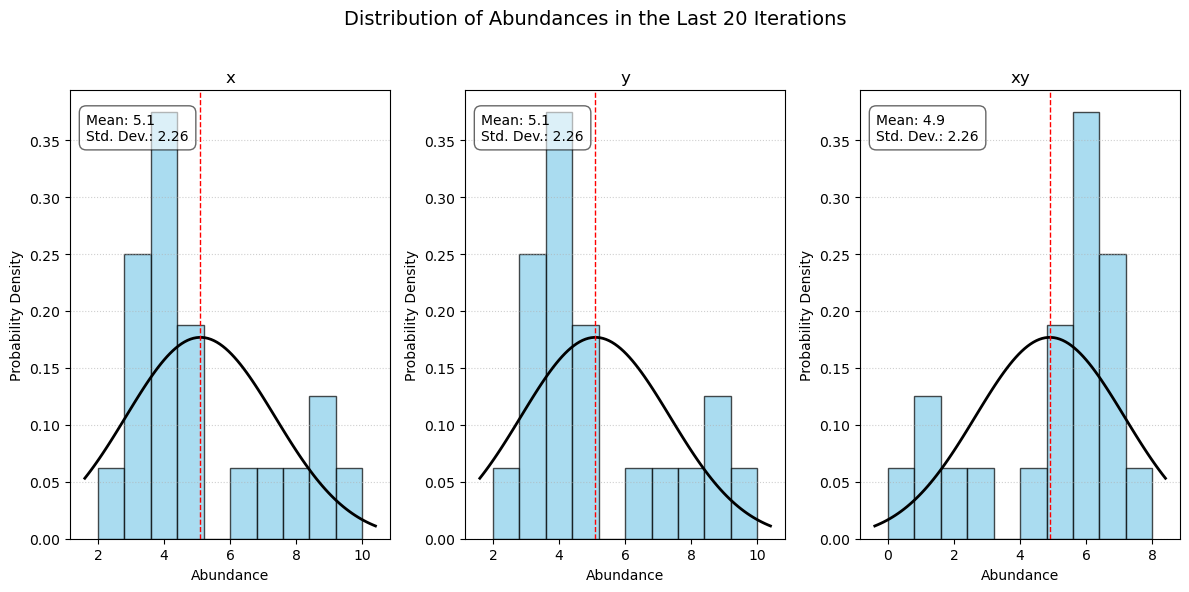

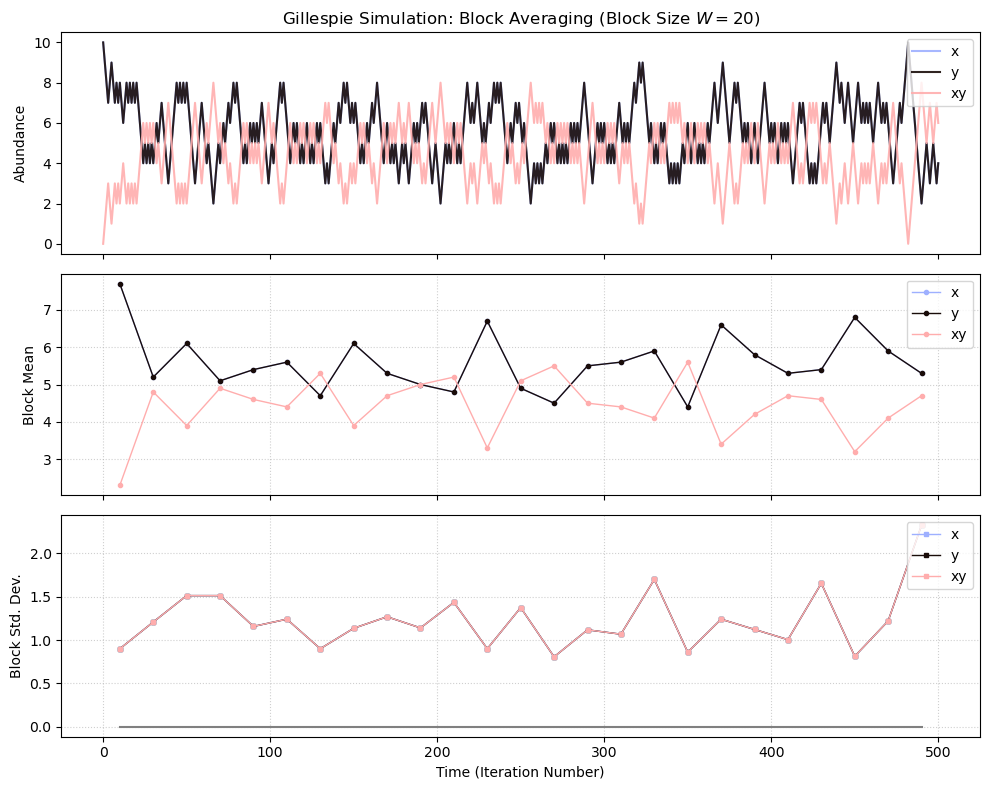

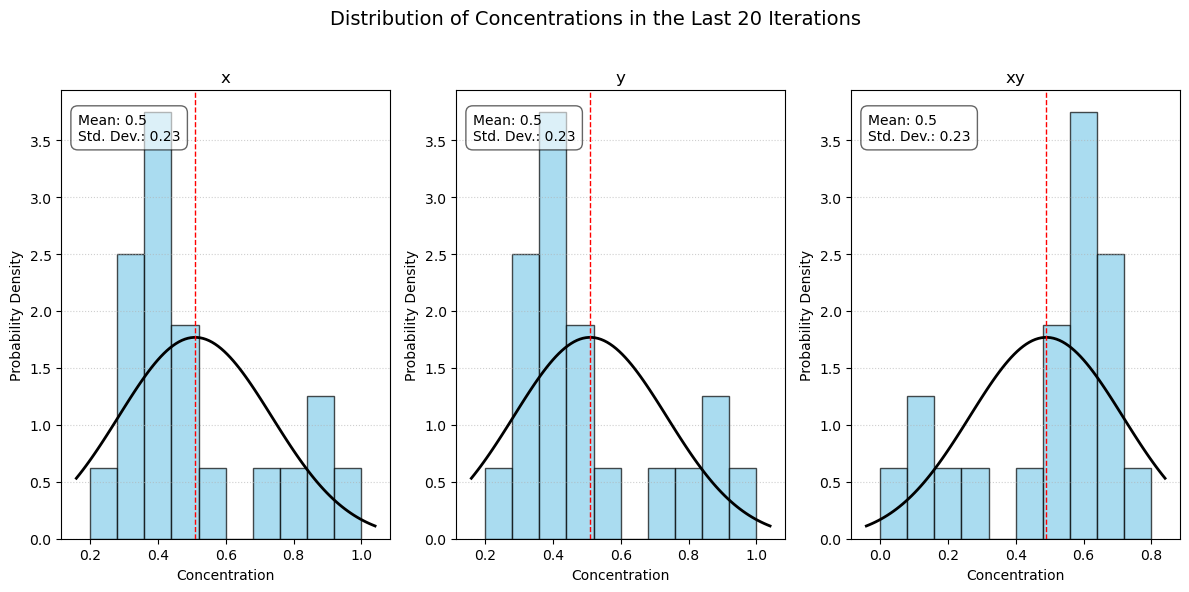

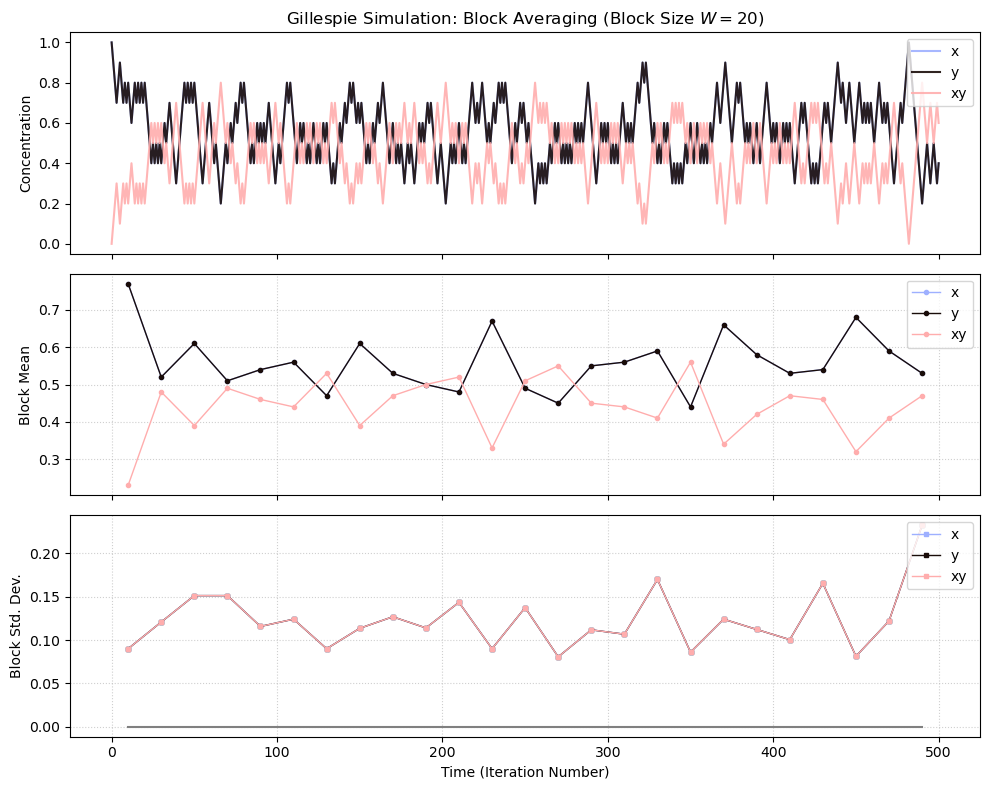

In [ ]:
W = 20
plotDistribution(W, abundances, species)
plot_block_statistics(abundances, W, species)
plotDistribution(W, concentration, species, ab= "Concentration")
plot_block_statistics(concentration, W, species, ab= "Concentration")

# Sistema autocatalitico

In [44]:
file = "../examples/reactions_autocat.txt"
reactions = read_file(file)
species = obtain_species(reactions)

In [45]:
k = [1]*8
initial = [1000]*4+[500]*2+[0]*2
volume = 1000

iterations = 14000
t = threshold_function(volume)
abundances, times, V = chemistry(method= "Protocell", iterations= iterations, reactions= reactions, initial_food= initial,
                                k= k, V = volume)

concentration = (abundances.T / V).T

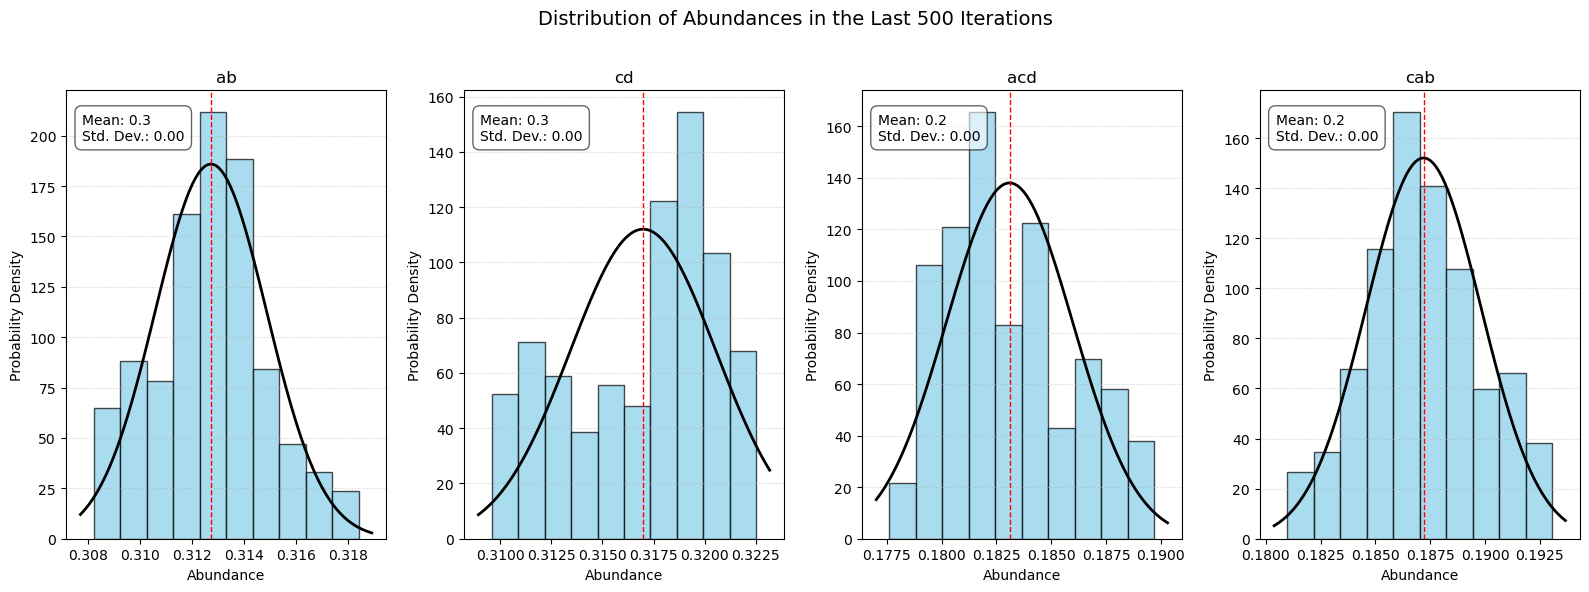

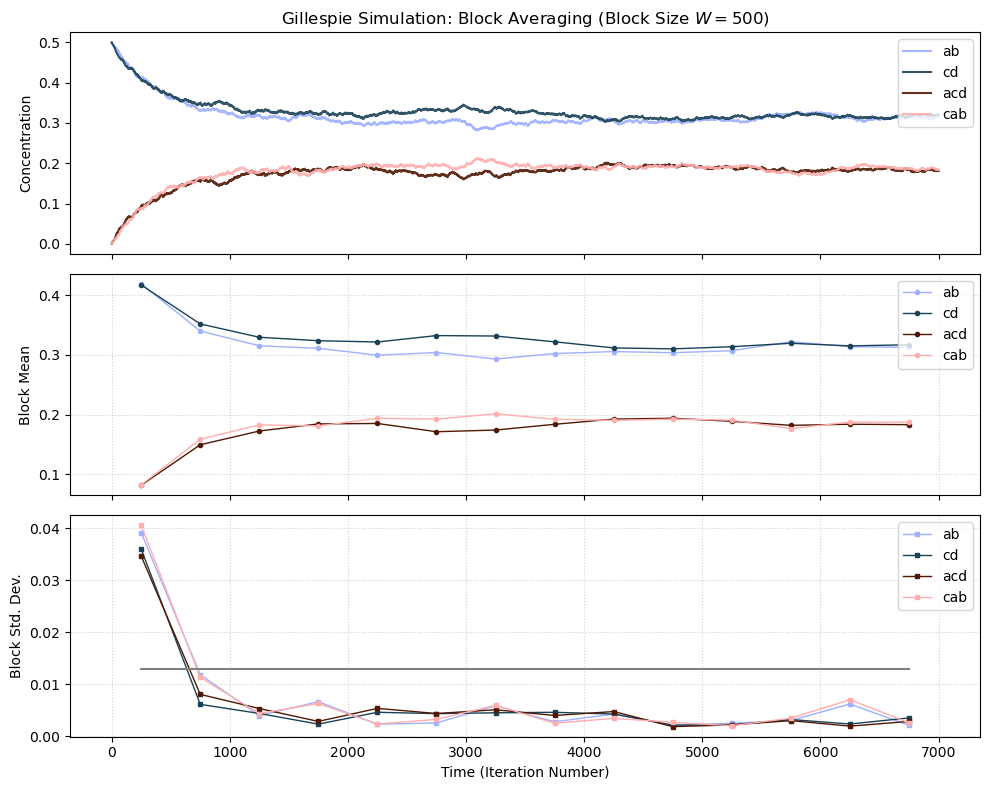

13

In [46]:
W = 500
plotDistribution(W, concentration[:,4:], species[4:])
plot_block_statistics(concentration[:,4:], W, species[4:], limit= t, ab= 'Concentration')
mean, std = block_statistics(concentration[:,-1], W)
np.sum(std<t)


In [47]:
for i in range(len(species)):
    mean, std = block_statistics(concentration[:,i], W)
    print(f'{species[i]} -> {np.sum(std<0.005)}')

a -> 14
b -> 14
c -> 14
d -> 14
ab -> 9
cd -> 12
acd -> 9
cab -> 9


In [48]:
k = [1]*8
initial = [100]*4+[500]+[0]*3
volume = 1000
t = threshold_function(volume)
iterations = 1e10
abundances, times, V = chemistry(method= "Protocell", iterations= iterations, reactions= reactions, initial_food= initial,
                                k= k, V = volume)

concentration = (abundances.T / V).T

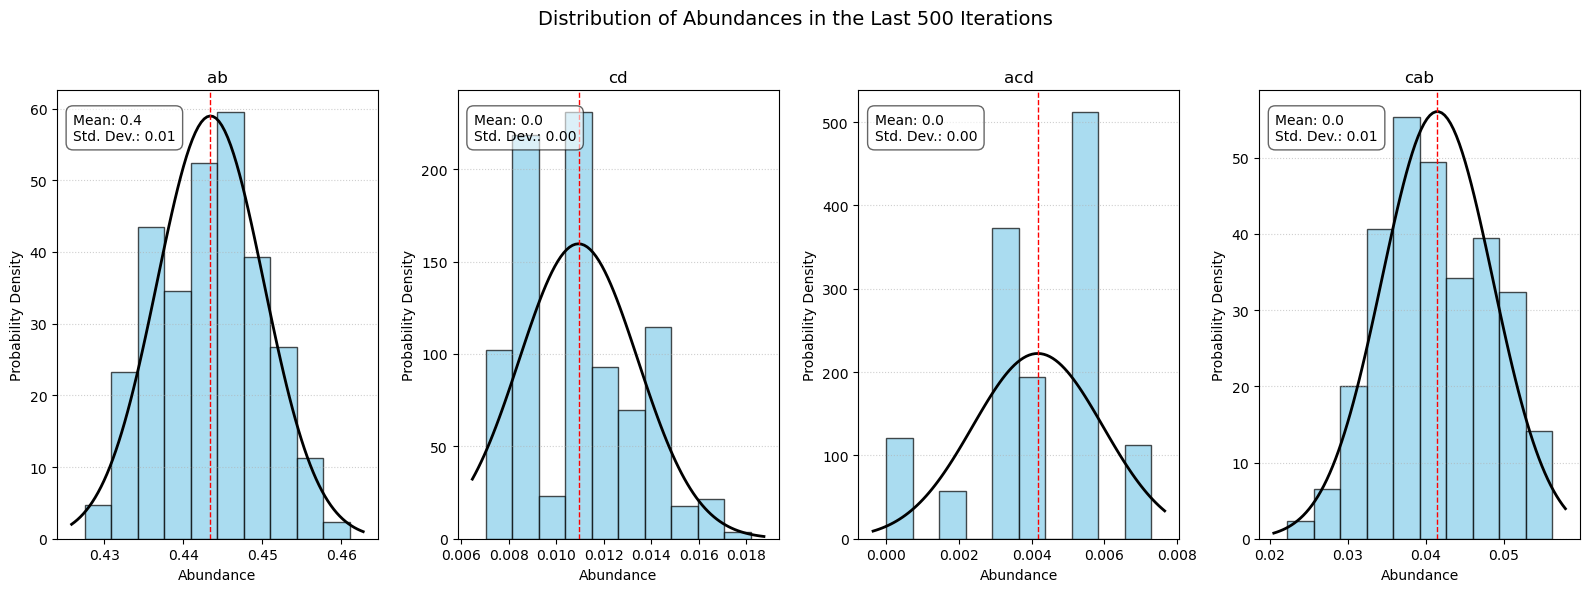

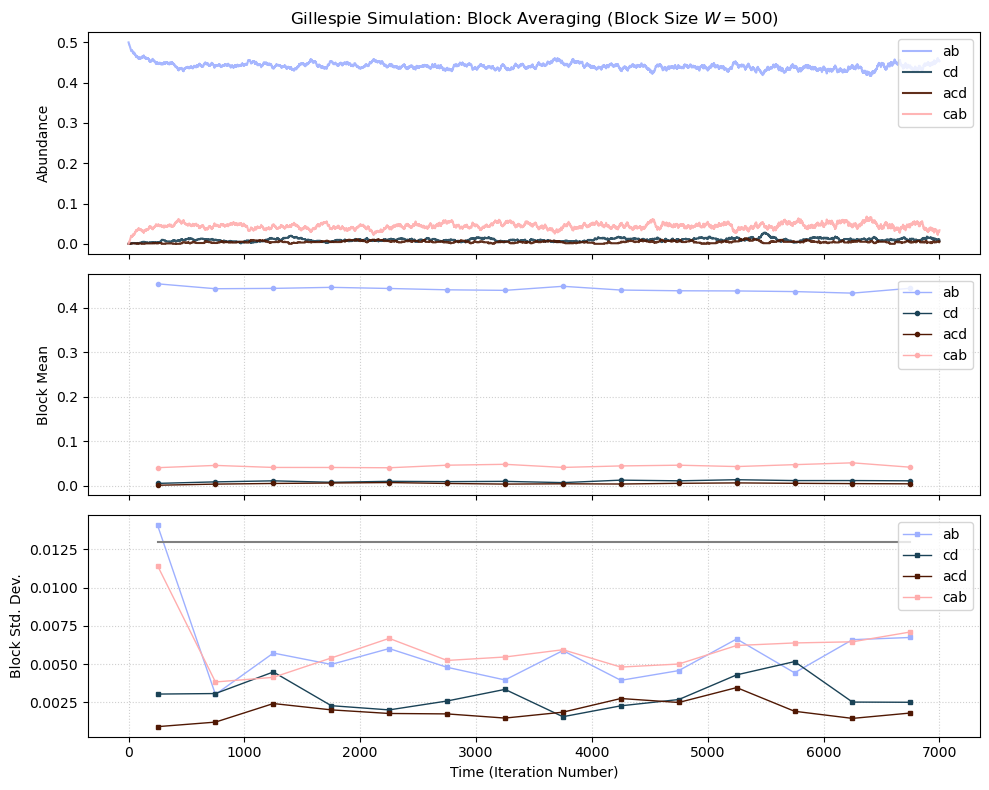

14

In [49]:
W = 500
plotDistribution(W, concentration[:,4:], species[4:])
plot_block_statistics(concentration[:,4:], W, species[4:], limit= t)
mean, std = block_statistics(concentration[:,-1], W)
np.sum(std<t)

In [50]:
for i in range(len(species)):
    mean, std = block_statistics(concentration[:,i], W)
    print(f'{species[i]} -> {np.sum(std<t)}')

a -> 14
b -> 14
c -> 14
d -> 14
ab -> 13
cd -> 14
acd -> 14
cab -> 14


In [51]:
k = [1]*8
initial = [1000]*4+[1000]+[0]*3
volume = 1000
t = threshold_function(volume)
iterations = 60000
abundances, times, V = chemistry(method= "Protocell", iterations= iterations, reactions= reactions, initial_food= initial,
                                k= k, V = volume)

concentration = (abundances.T / V).T

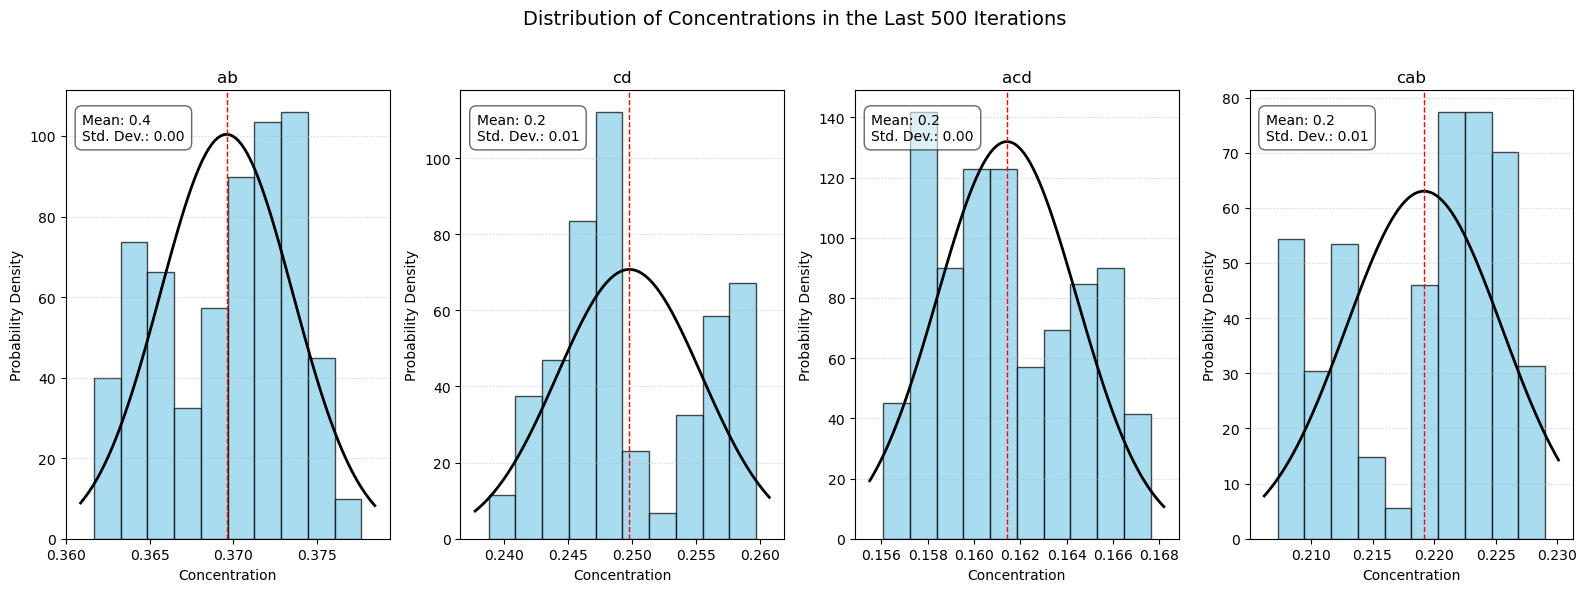

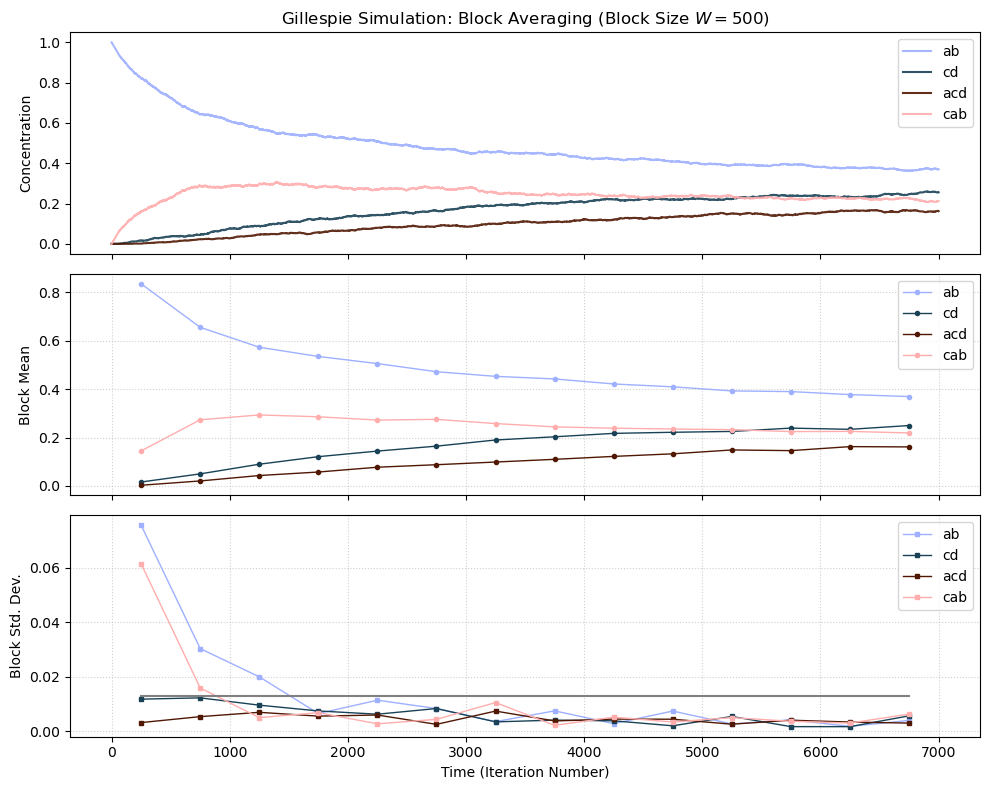

12

In [52]:
W = 500
plotDistribution(W, concentration[:,4:], species[4:], ab= "Concentration")
plot_block_statistics(concentration[:,4:], W, species[4:], limit= t, ab='Concentration')
mean, std = block_statistics(concentration[:,-1], W)
np.sum(std<t)

In [53]:
for i in range(len(species)):
    mean, std = block_statistics(concentration[:,i], W)
    print(f'{species[i]} -> {np.sum(std<t)}')

a -> 14
b -> 14
c -> 14
d -> 14
ab -> 11
cd -> 14
acd -> 14
cab -> 12


### Para volumenes alrededor de 100

In [54]:
k = [1]*8
initial = [100]*4+[50]*2+[0]*2
volume = 100
t = threshold_function(volume)
iterations = 20000
abundances, times, V = chemistry(method= "Protocell", iterations= iterations, reactions= reactions, initial_food= initial,
                                k= k, V = volume)

concentration = (abundances.T / V).T

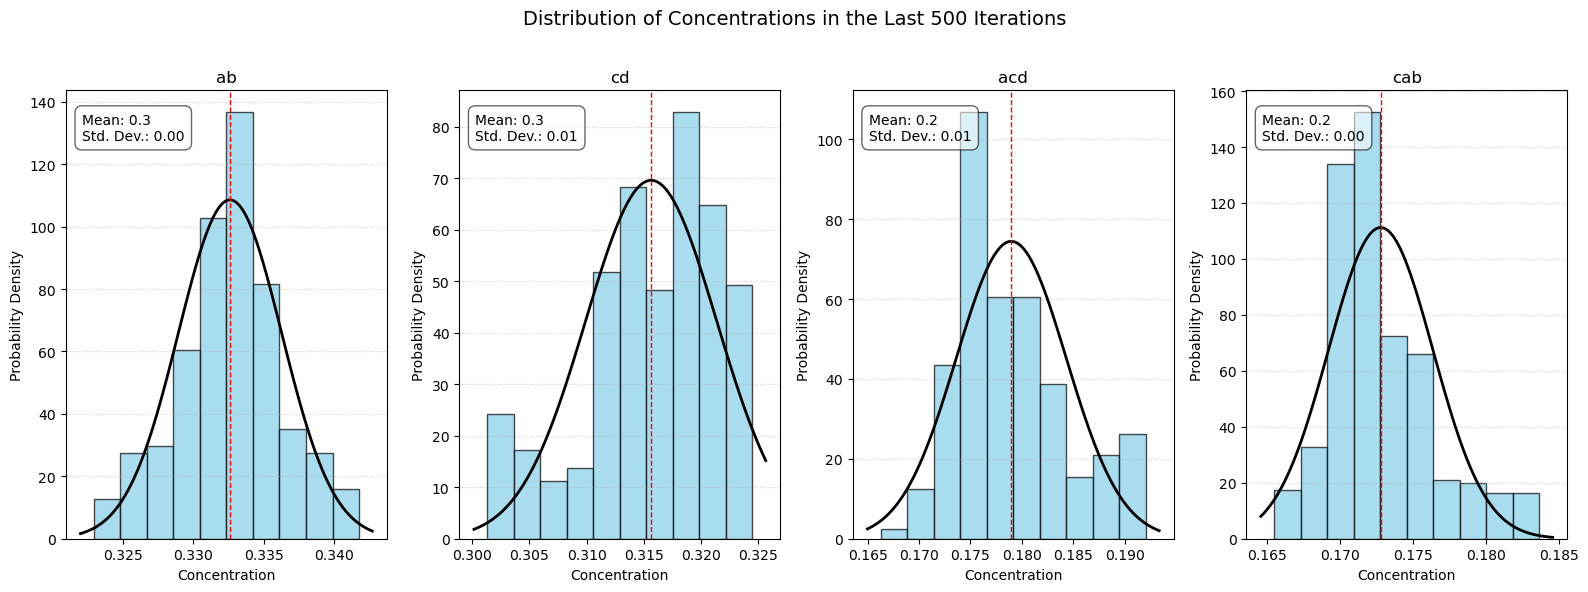

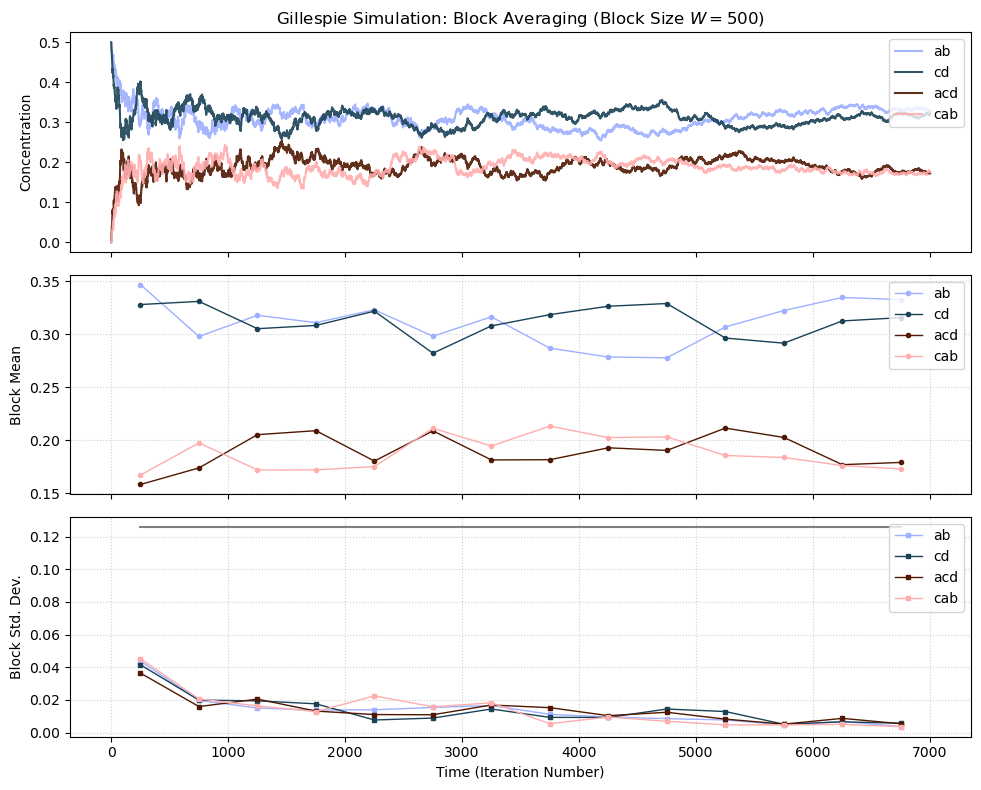

a -> 14
b -> 14
c -> 14
d -> 14
ab -> 14
cd -> 14
acd -> 14
cab -> 14
0.1260338795950606


In [55]:
W = 500
plotDistribution(W, concentration[:,4:], species[4:], ab= "Concentration")
plot_block_statistics(concentration[:,4:], W, species[4:], limit= t, ab= "Concentration")
mean, std = block_statistics(concentration[:,-1], W)

for i in range(len(species)):
    mean, std = block_statistics(concentration[:,i], W)
    print(f'{species[i]} -> {np.sum(std<t)}')
    
print(t)

In [56]:
k = [1]*8
initial = [100]*4+[100]*2+[0]*2
volume = 100
t = threshold_function(volume)
iterations = 60000
abundances, times, V = chemistry(method= "Protocell", iterations= iterations, reactions= reactions, initial_food= initial,
                                k= k, V = volume)

concentration = (abundances.T / V).T

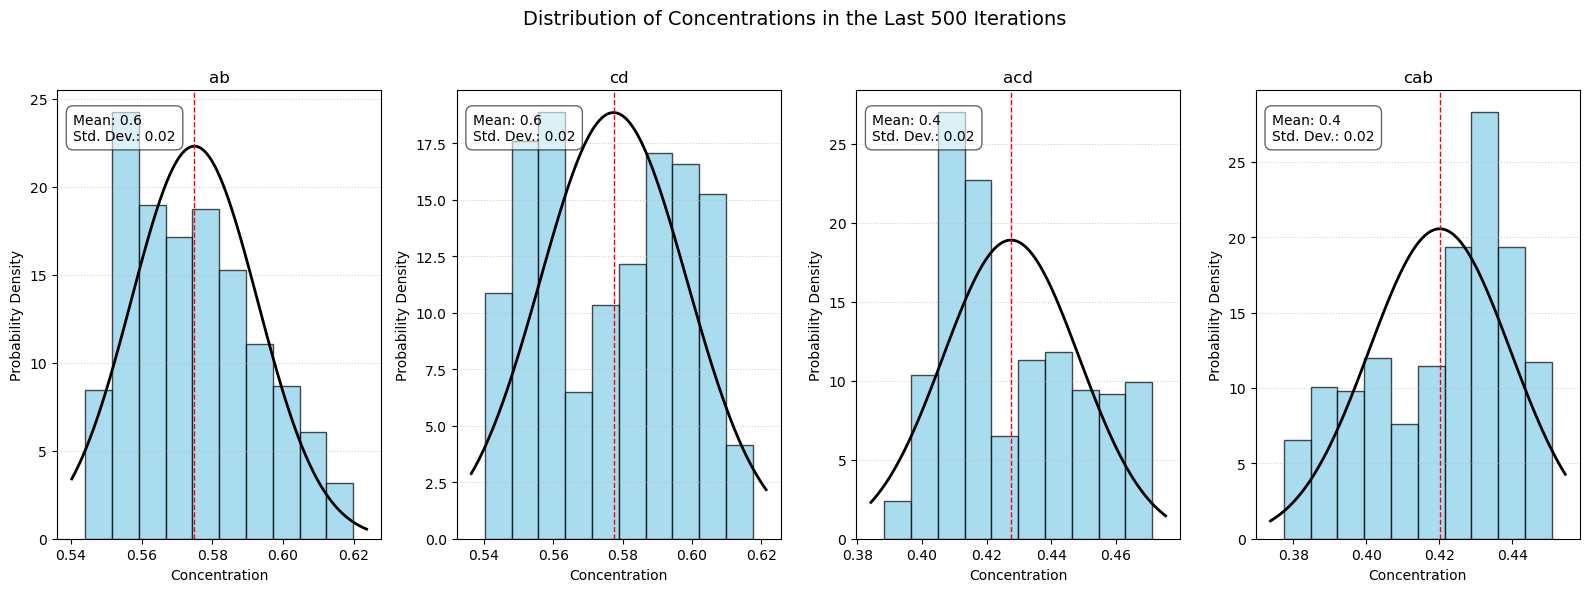

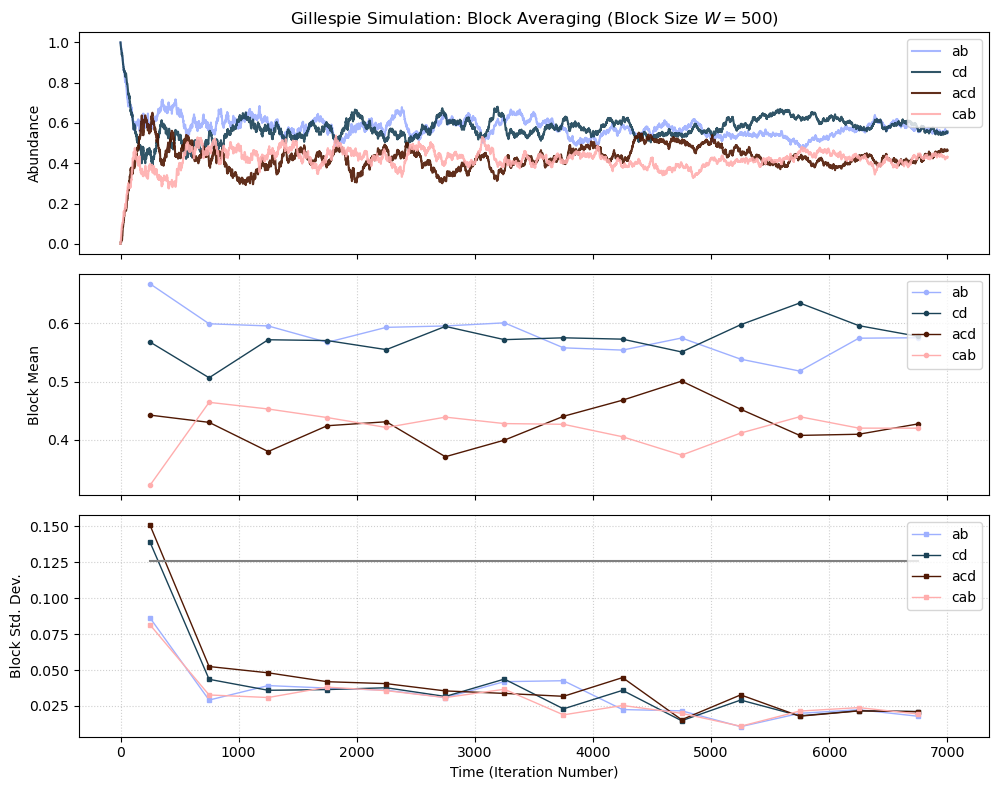

14

In [57]:
W = 500
plotDistribution(W, concentration[:,4:], species[4:], ab= "Concentration")
plot_block_statistics(concentration[:,4:], W, species[4:], limit= t)
mean, std = block_statistics(concentration[:,-1], W)
np.sum(std<t)

In [58]:
for i in range(len(species)):
    mean, std = block_statistics(concentration[:,i], W)
    print(f'{species[i]} -> {np.sum(std<t)}')

a -> 14
b -> 14
c -> 14
d -> 14
ab -> 14
cd -> 13
acd -> 13
cab -> 14


In [59]:
n_iterations = 10000
method = "Protocell" # Gillespie or Deterministic
# Reaction constants:
k = [1]*8 # len(k)= # de reacciones
# Volume:
V = 200
initial_food = [200]*4 + [200]*2 + [0]*2 # initial molecules number
t = threshold_function(volume)
abundances, times, V = chemistry(method, n_iterations, reactions,
                                initial_food, k, V)

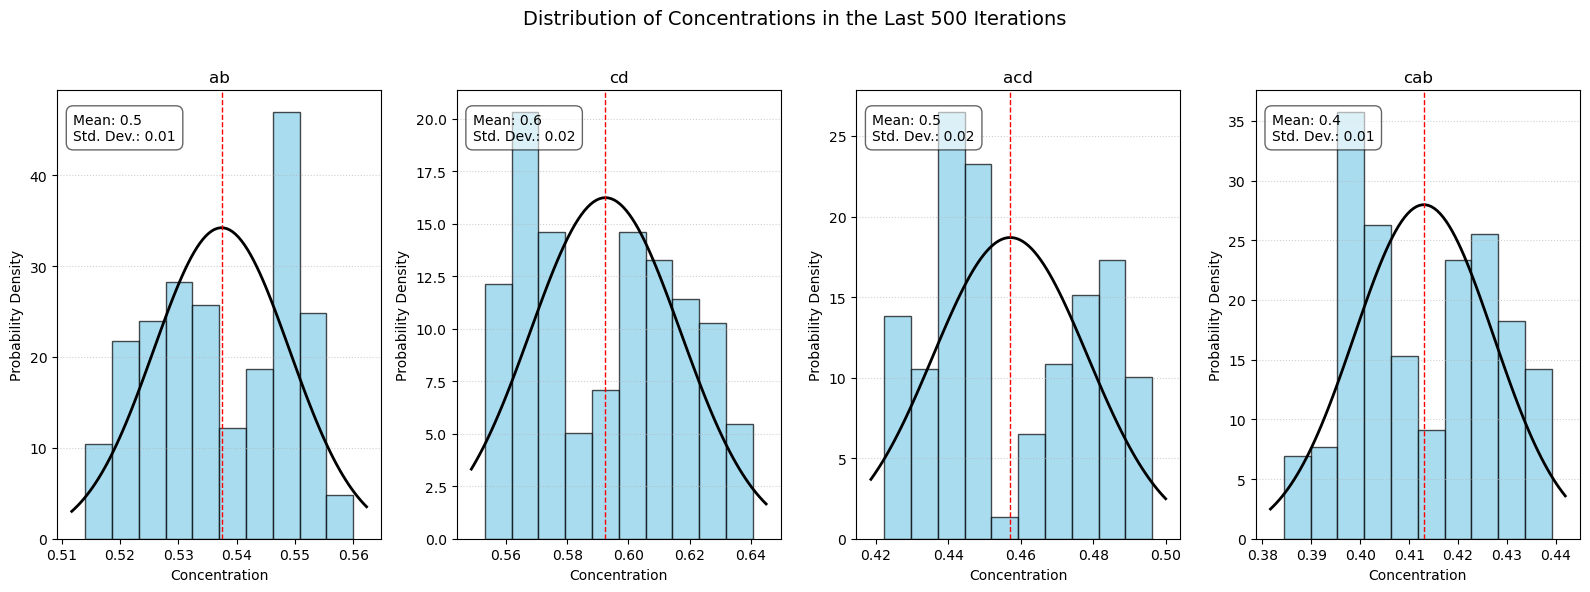

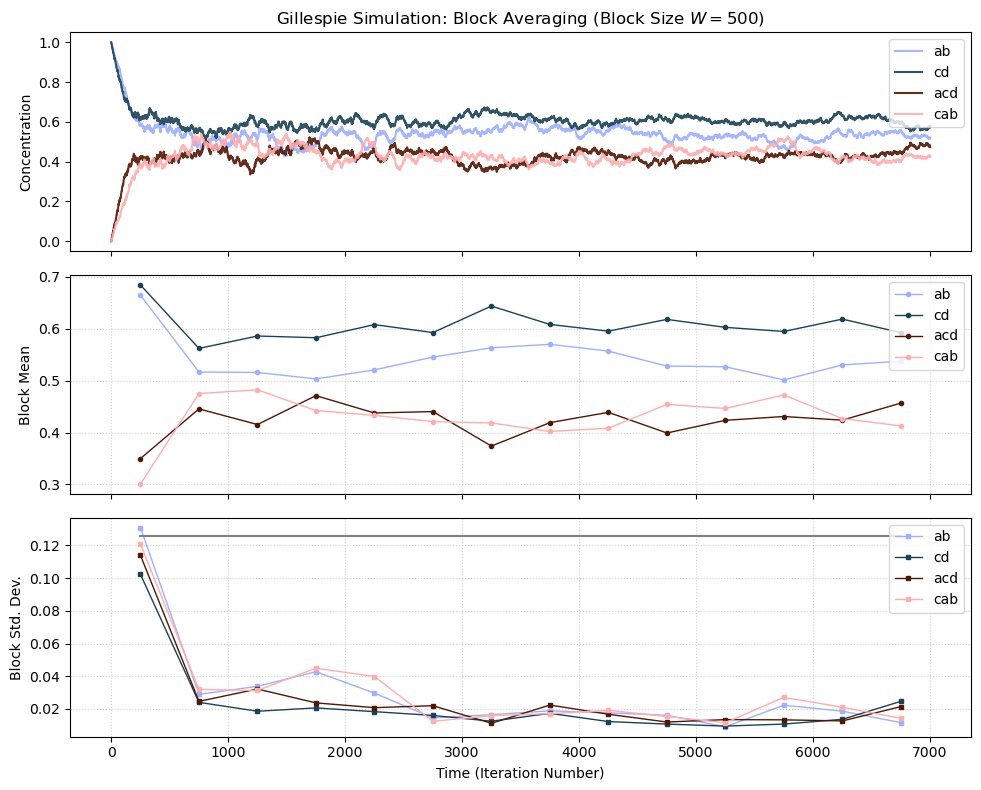

14

In [60]:
concentration = (abundances.T / V).T
W = 500
plotDistribution(W, concentration[:,4:], species[4:], ab= "Concentration")
plot_block_statistics(concentration[:,4:], W, species[4:], limit= t, ab= "Concentration")
mean, std = block_statistics(concentration[:,-1], W)
np.sum(std<t)

In [61]:
k = [1]*8
initial = [10000]*4+[5000]*2+[0]*2
volume = 10000

iterations = 60000
t = threshold_function(volume)
abundances, times, V = chemistry(method= "Protocell", iterations= iterations, reactions= reactions, initial_food= initial,
                                k= k, V = volume)

concentration = (abundances.T / V).T

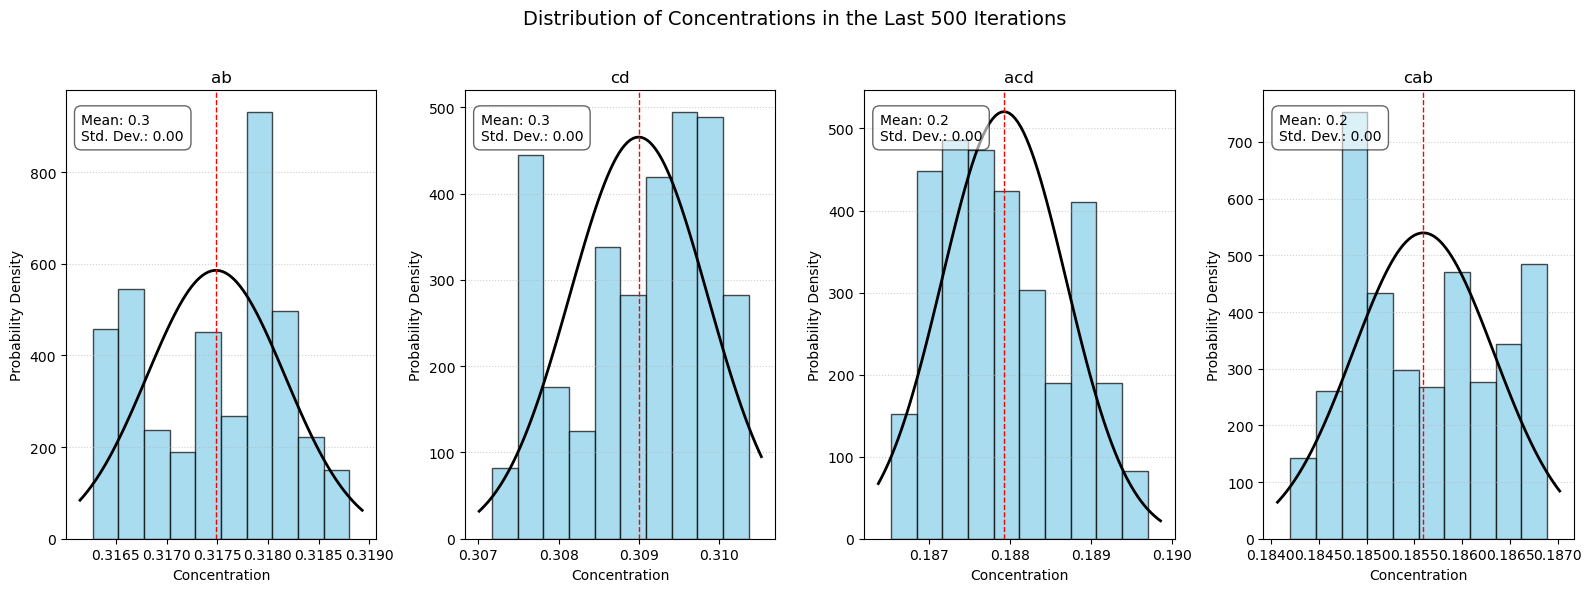

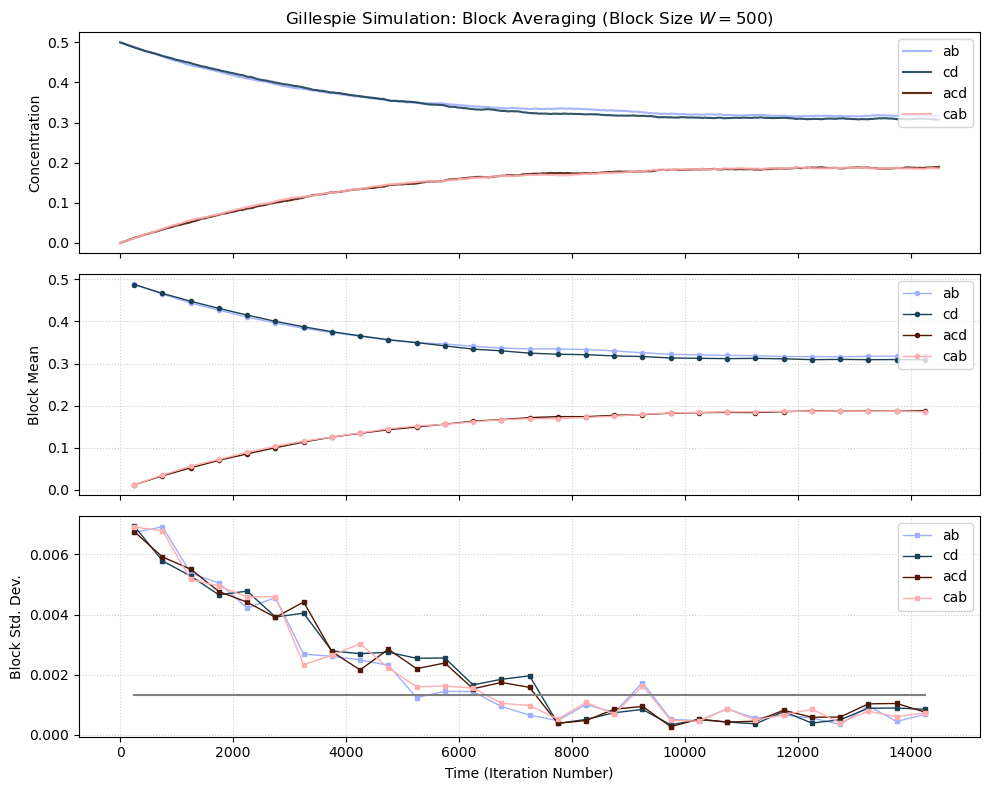

15

In [62]:
W = 500
plotDistribution(W, concentration[:,4:], species[4:], ab= "Concentration")
plot_block_statistics(concentration[:,4:], W, species[4:], limit=t , ab= "Concentration")
mean, std = block_statistics(concentration[:,-1], W)
np.sum(std<t)

In [63]:
k = [1]*8 # len(k)= # de reacciones
# Volume:
V = 1e5
initial_food = [1e5]*4 + [5e4]*2 + [0]*2 # initial molecules number
n_iterations = 1e10
abundances, times, V = chemistry(method, n_iterations, reactions,
                                initial_food, k, V)

concentration = (abundances.T / V).T

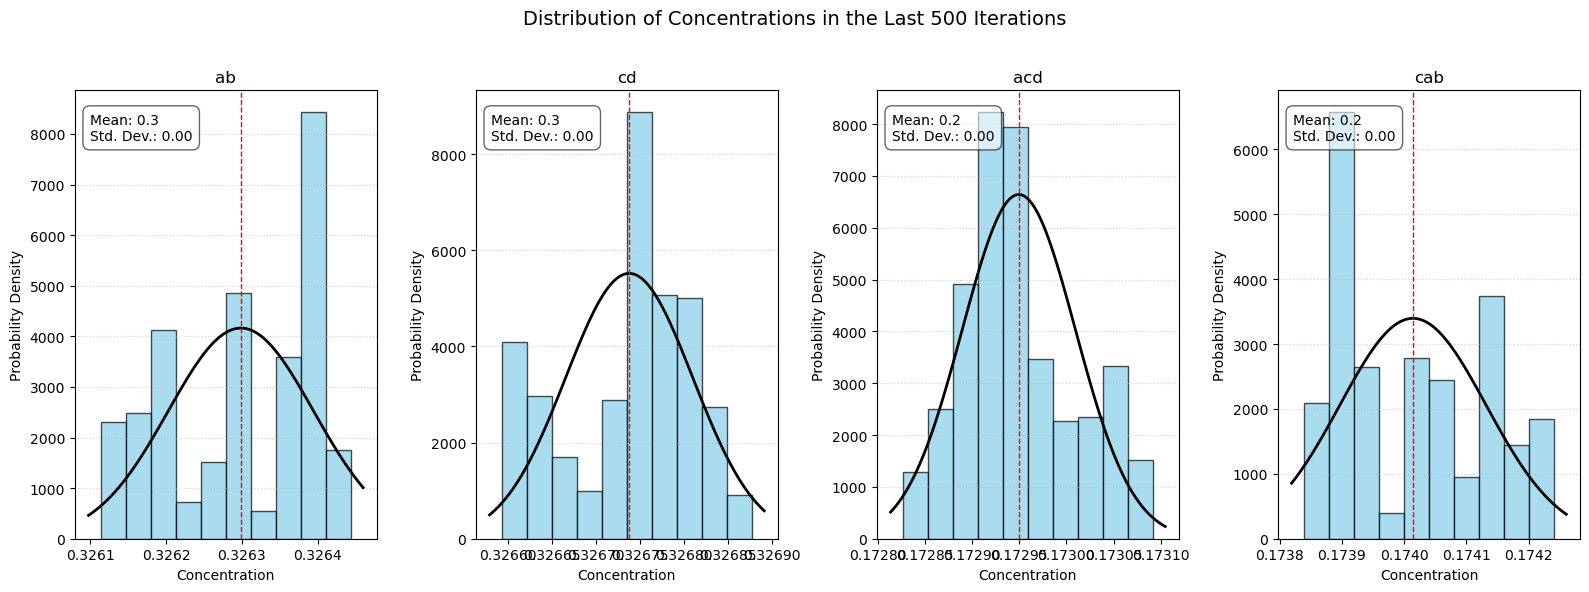

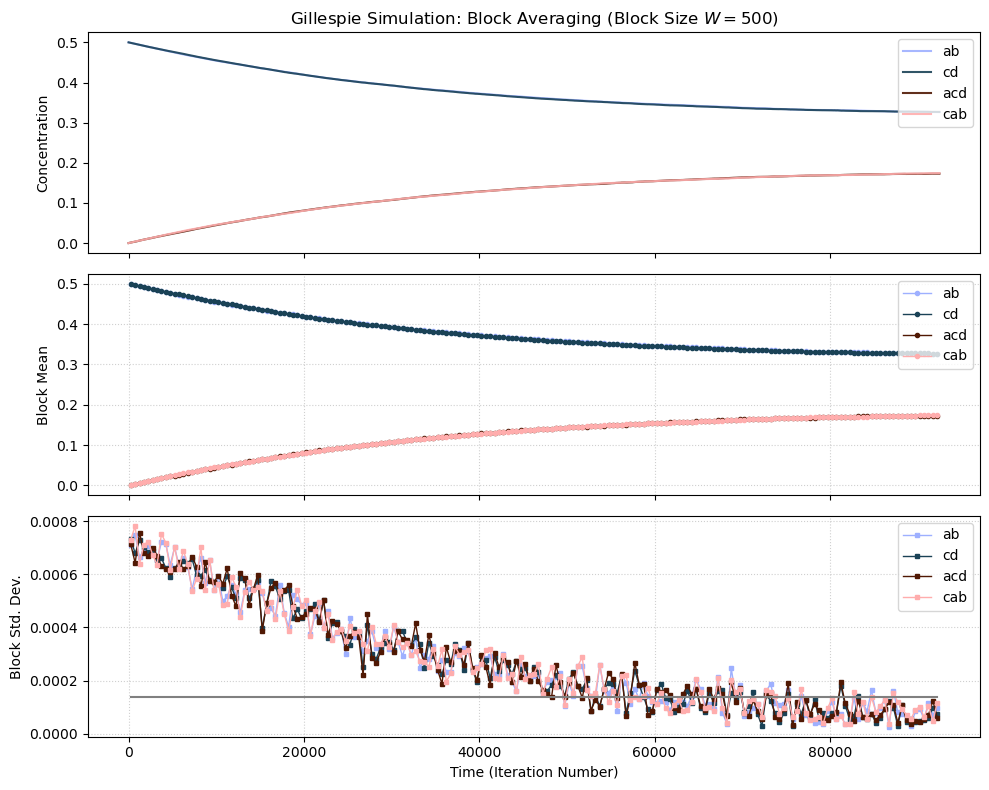

59

In [64]:
W = 500
t = threshold_function(V[0])
plotDistribution(W, concentration[:,4:], species[4:], ab= "Concentration")
plot_block_statistics(concentration[:,4:], W, species[4:], limit=t , ab= "Concentration")
mean, std = block_statistics(concentration[:,-1], W)
np.sum(std<t)